# 0. Library Imports

In [20]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import product
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import GaussianBlur
import requests
import gdown
import copy
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn import metrics
from torchvision import transforms, datasets, models
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights 
from PIL import Image
from torchvision.models import EfficientNet_V2_M_Weights,efficientnet_v2_m
from torchvision.models.mobilenetv3 import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import gc
from tqdm import tqdm,trange
from visdom import Visdom



# 1. Introduction

## 1.1 AIGC History 

According to survey on  AIGC content by Cao et al. [1],   Generative Models in Ai can be traced back to the 1950s with inception of important techniques such as Hidden Markov Models and Gaussian Mixture Models which pivoted development in generating sequential such as speech and time series. Generative models have had significant advancements due to the delopment of deep learning in natural language processing and computer vision tasks. Early nantural language processing tecniques relying on N-gram language modelling was side stepped with techniques such as Recurrent Neural Networks,  Long Short-Term Memory and Gated Recurrent Unit architectures. Computer vision advancement brokethrough via Generative Adverserial Networks in 2014, opening the floodgates for complex and differnet image sysntheses. NLP models utilizing generative models like BERT and GPT impacted CV models thorugh the inception of Vision Transformer and SWIn transformer creating the base for multimodal tasks like CLIP. 

## 1.2 AIGC Problems 

AUGC content has raised multiple privacy, security and ethical concerns.  In the field of factual text,  AIGC text can have  aprepensity to provide factually inaccurate and inconsistent data due to training limitations or biased training.  In the field of imags,  AIGC images raise ethical and social issues with the usage of with creation of unsolicited deepfakes, IP infringemnt via the trainign data and eviscerating the cultural and artistic environment of possible authentic and labour-curated image. 

## 1.3 Motivation Statement 

In the context of this project,  AIGC models have seen significant advancements in image generation where real images cannot be differentiatied with AIGC images with the naked eye as seen in the survey by Pocol et al. [2], where only 61% of respondents could tell the difference between an AIGC image and a real image, lower than the 85% threshold expected by the researchers. Now more than ever, An AIGC detection tool is needed to assist in generated content detection to make sure image can be attributed to the correct sources and cannot be used for nefarious purposes.  


# 2. Strategy, Settings and Parameters

## 2.1 Strategy

### 2.1.1 Ensemble Approach
The main strategy of this project is to apply ensemble approach for 4 types of models mentioned during lecture: **ViT**, **ResNet**, **EfficiencyNet** and **MobileNet**. To achieve ensembling of these models, the final decision for classification will be determined by weighting each model's output, where the final classification result is be based on the combined weighted outputs of these models, ensuring that their individual contributions are considered in the overall prediction. Since the models have different architectures, the goal is to capture varying details from the same image in order to increases robustness and enhances the diversity of features, leading to improved classification accuracy. To ensure fairness, the contribution of each model m to the ensenble result will based on their performance P on the test dataset using the following formula (Performance-based Weighting): 

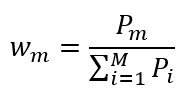

### 2.1.2 Transfer Learning
The model weights will not use self-defined initialization. Instead, pre-trained weights from ImageNet will be loaded into the corresponding models to serve as initial weights before training. During the training process, these weights will be fine-tuned using different parameter combinations and data augmentations to achieve the best observable validation accuracy. 

### 2.1.3 Best Weights Preservation
During the models' individual training, weights will be saved each time a new highest validation accuracy is achieved. This ensures that the best-performing model states are preserved, allowing them to be used later for further evaluation, comparison, or fine-tuning.

### 2.1.4 Phase Planing
This project consists of two phases. In **Phase 1: Experiments**, the main objective is to train the models using simple augmentations and various parameter combinations (learning rates and weight decays) to observe their classification performance and learning behaviors under the same conditions. In **Phase 2: Adjustments**, adjustments will be made based on the TA's accuracy testing results and the model behaviors observed during Phase 1.

### 2.1.5 Work Distribution
To facilitate model training, each member of the group will be responsible for training two models in both Phase 1 and Phase 2. After the accuracy test results from the TA are available, we will analyze the performance and apply our own unique approaches to adjust and refine our respective models. This individualized strategy allows each member to experiment with different training techniques, hyperparameter tuning, and architectural adjustments, alowing diversity in methodologies and enabling a richer exploration of model training techniques. 
| Name |  Responsibility   |
|-------|---------------|
| Twan Tsz Yin| ViT, ResNet |
| Sid|   EfficientNet, MobileNet   |



## 2.2 Settings

### 2.2.1 Initialization

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

#Test Loader
batch_size = 128
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])
train_data_path ="C:/ml/AIGC-Detection-Dataset/val"
test_dataset = ImageFolder(train_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


Using device: cuda


### 2.2.2 Folder structure
```
AIGC-Detection-Dataset
│
├── train
│   │
│   ├── 0_real (22,500)
│   └── 1_fake (22,500)
│
└── val
    │
    ├── 0_real (2,500)
    └── 1_fake (2,500)
```

### 2.2.3 Training and validation set


The train folder is split into training set and validation set, which are used for the evaluation during training. The val folder is used for testing the models' performance with best preserved weights after the training loops are complete.

Spliting of training set:
| Purpose |  Percentage   |
|-------|---------------|
| Training|       90%     |
| Validation|     10%    |



## 2.3 Functions

In [14]:
def plot_training_metrics(file_path, group_by="default"):
    data = pd.read_excel(file_path)

    if group_by == "same_lr":
        unique_combinations = data[['Learning Rate', 'min_delta']].drop_duplicates()
        legend_label = lambda row: f"LR: {row['Learning Rate']}, min_delta: {row['min_delta']}"
        group_keys = ['Learning Rate', 'min_delta']
    elif group_by == "freeze":
        unique_combinations = data[['Freeze Percentage']].drop_duplicates()
        legend_label = lambda row: f"Freeze %: {row['Freeze Percentage']}"
        group_keys = ['Freeze Percentage']
    elif group_by == "resnet":
        unique_combinations = data[['Dropout Rate', 'Restart Epoch']].drop_duplicates()
        legend_label = lambda row: f"Dropout: {row['Dropout Rate']}, Restart Epoch: {row['Restart Epoch']}"
        group_keys = ['Dropout Rate', 'Restart Epoch']
    else:
        unique_combinations = data[['Weight Decay']].drop_duplicates()
        legend_label = lambda row: f"WD: {row['Weight Decay']}"
        group_keys = ['Weight Decay']

    colors = plt.cm.tab10(range(len(unique_combinations)))
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    def get_subset(row):
        condition = True
        for key in group_keys:
            condition &= data[key] == row[key]
        return data[condition]

    metrics = ['Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy']
    titles = ['Train Loss for All Parameter Combinations',
              'Validation Loss for All Parameter Combinations',
              'Train Accuracy for All Parameter Combinations',
              'Validation Accuracy for All Parameter Combinations']
    y_labels = ['Loss', 'Loss', 'Accuracy (%)', 'Accuracy (%)']

    for metric_idx, metric in enumerate(metrics):
        for i, (_, row) in enumerate(unique_combinations.iterrows()):
            subset = get_subset(row)
            label = legend_label(row)
            if group_by == "freeze":
                freeze_color = plt.cm.viridis(row['Freeze Percentage'] / 100)
                axes[metric_idx].plot(subset['Epoch'], subset[metric], label=label, color=freeze_color)
            else:
                axes[metric_idx].plot(subset['Epoch'], subset[metric], label=label, color=colors[i % len(colors)])

        axes[metric_idx].set_title(titles[metric_idx])
        axes[metric_idx].set_xlabel('Epoch')
        axes[metric_idx].set_ylabel(y_labels[metric_idx])
        axes[metric_idx].grid()
        axes[metric_idx].legend()

    plt.tight_layout()
    plt.show()

#Intropducing Dropout to ResNet50
class ResNet50WithDropout(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ResNet50WithDropout, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, 2)  
        )

    def forward(self, x):
        return self.resnet(x)  
      
def evaluate_model(model, weight_path, test_loader, device, model_type=None, dropout_rate=0.3):
    if model_type == "dropout":
        model = ResNet50WithDropout(dropout_rate=dropout_rate)

    model.load_state_dict(torch.load(weight_path))
    model.to(device)
    model.eval()

    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy

def free_mem():
    try:
        del model,images,labels
    except:                                                                                                                                         
        pass
    gc.collect()
    torch.cuda.empty_cache()
    
free_mem()

## 2.3 Initial Parameters & Image Augmentations (Phase 1)

### 2.3.1 Parameters in Training Loops

In [5]:
learning_rates = [1e-5,1e-6]
num_epochs_list = [30]
weight_decays = [1e-5,1e-6]

The model trainings in phase 1 used the above parameters, where each combination of learning rate and weight decay are trained through 30 epochs, and accruacies and losses in each epoch will be recorded. The weights with best validation accuracy among all epochs and combinations will preserved for ensembling. 

### 2.3.2 Simple Image Augmentations (Phase 1)

To standardize the input of all models, the input images are converted to 224x224 resolution using RandomResizedCrop(224) before passing to the model for training.

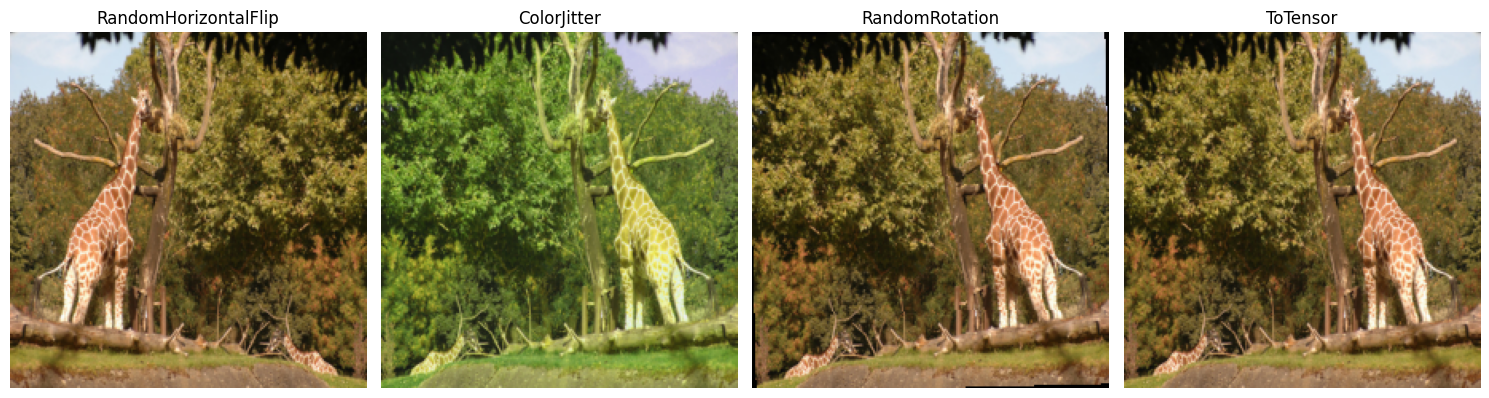

In [ ]:
individual_transforms = [
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
]
random_crop = transforms.Compose([
    
    transforms.Resize((224,224)),  
])
image_path = 'C:/ml/AIGC-Detection-Dataset/train/0_real/000000000025.jpg'
original_image = Image.open(image_path).convert('RGB')
plt.figure(figsize=(15, 5))
for i, transform in enumerate(individual_transforms):
    cropped_image = random_crop(original_image)
    if isinstance(transform, transforms.ToTensor):
        transformed_image = transform(cropped_image)
        transformed_image = transforms.ToPILImage()(transformed_image)
    else:
        transformed_image = transform(cropped_image)
    plt.subplot(1, len(individual_transforms), i + 1)
    plt.imshow(transformed_image)
    plt.title(f"{type(transform).__name__}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# 3. Phase 1: Experiment

## 3.1 Visual Transformer (ViT) - Twan Tsz Yin

### 3.1.1 Background


The Vision Transformer (ViT) model follows the Transformer architecture that is originally designed for natural language processing to image recognition tasks [3]. It splits an image into fixed-size patches, linearly embeds each patch into a vector, and adds positional embeddings to retain spatial information. An extra learnable "classification token" is added to the sequence, which, along with the patch embeddings, is fed into a Transformer encoder consisting of multiple Transformer blocks for feature extraction. Finally, a classification head processes the output to make predictions, demonstrating strong performance on image classification benchmarks.

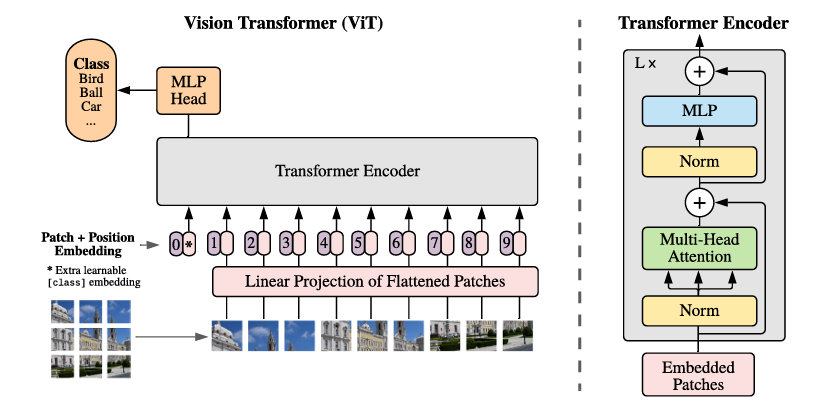

The model used in this project is ViT-Base (vit_b_16), the smallest variation of Vision Transformer, which splits an image into fixed-size 16x16 patches, processes them through 12 layers of Transformer blocks, and has a total of 86M parameters. 

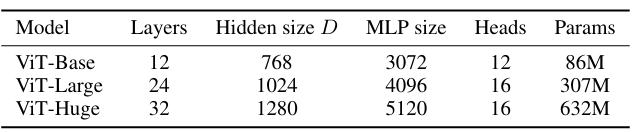

The ViT model used in this project is ViT_b_16, implemented using PyTorch. The initial weights used for the model are IMAGENET1K_V1, which were pre-trained on the ImageNet-1K dataset. These weights were trained using a modified version of the training recipe from Data-Efficient Image Transformers (DeiT). This pre-training provides the model with a strong foundation for recognizing generic features, which are further fine-tuned for the specific task in this project. Refer to the following figure for further details [4]:

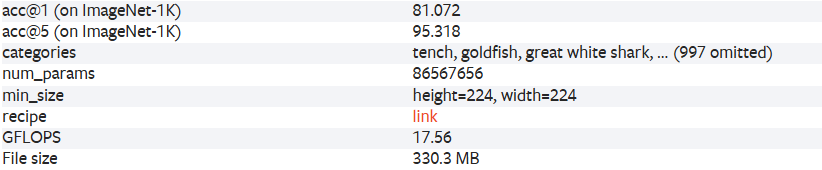

### 3.1.2 ViT Training Evaluation

<>:1: SyntaxWarning: invalid escape sequence '\V'
<>:1: SyntaxWarning: invalid escape sequence '\V'
C:\Users\dgoli\AppData\Local\Temp\ipykernel_33752\2610589135.py:1: SyntaxWarning: invalid escape sequence '\V'
  file_path = 'output\ViT_Log_no_aug_new.xlsx'


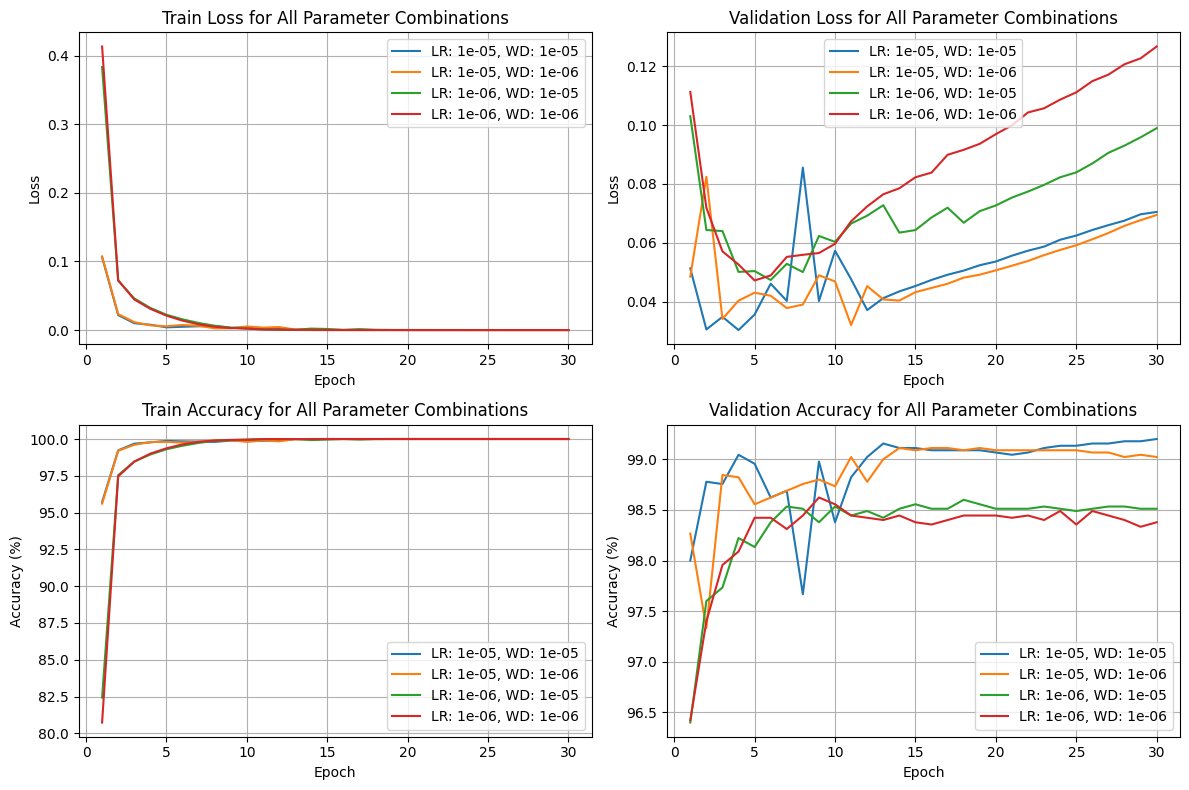

In [ ]:
file_path = 'output\ViT_Log_no_aug_new.xlsx'  
plot_training_metrics(file_path)

The top 3 records with highest validation accuracy during training:
| Epoch | Learning Rate | Num Epochs | Weight Decay | Train Loss   | Train Accuracy | Validation Loss | Validation Accuracy |
|-------|---------------|------------|--------------|--------------|----------------|-----------------|---------------------|
| 30    | 0.00001       | 30         | 0.00001      | 1.91135E-07  | 100            | 0.070486583     | 99.2               |
| 28    | 0.00001       | 30         | 0.00001      | 3.02647E-07  | 100            | 0.067540736     | 99.17777778        |
| 29    | 0.00001       | 30         | 0.00001      | 2.36231E-07  | 100            | 0.06968754      | 99.17777778        |

From the training graphs, the learning rate has demonstrated a more influential role in model training compared to weight decay during the training phase of ViT_b_16. However, the impact of weight decay is more evident in the behavior of the validation loss.

During the first 5 epochs, the training loss for both learning rates decreased significantly. For example, the training loss dropped from 0.4131 to 0.0210 for lr=1e-6 in the first 5 epochs, representing a 94% reduction. This indicates that the ViT_b_16 model was learning extremely fast within the initial 5 epochs. This rapid learning is also reflected in other metrics, as there were noticeable increases in both training and validation accuracy. Additionally, for all learning rate combinations, the validation loss reached a near-global minimum around epoch 5. 

As the ViT_b_16 model progressed through more epochs, no further improvements were observed in overall training loss, accuracy and eventually validation accuracy, as they had plateaued quickly. However, the validation loss began to increase gradually throughout the remaining epochs, suggesting that the model was becoming increasingly uncertain about its outputs when evaluated on unseen data.

The increasing validation loss, stagnation in training loss, training accuracy, and validation accuracy suggests that the model began to overfit on the training data. This overfitting pattern shows that the model struggled to generalize to new data, as it became more focused on memorizing specific patterns in the training set rather than learning general features. As a result, its predictions on unseen data became less reliable, which is evident from the increase in validation loss, even though it achieved perfect accuracy on the training set.

### 3.1.3 ViT Testing Accuracy 

In [ ]:
model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
model.heads.head = nn.Linear(model.heads.head.in_features, 2)
evaluate_model(model, "submit/vit_b16_weights.pth", test_loader, device)


C:\Users\dgoli\AppData\Local\Temp\ipykernel_39776\1658215466.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Test Accuracy: 99.18%


99.18

## 3.2 ResNet50 - Twan Tsz Yin

### 3.2.1 Background


ResNet-50 is one of the variants of the ResNet architecture. It contains a 50-layer convolutional neural network designed with residual blocks that use skip connections to facilitate gradient flow and enable efficient training of deep networks [5]. The Achitecture of ResNet50 begins with a 7x7 convolutional layer and max pooling, followed by four stages of bottleneck residual blocks (1x1, 3x3, and 1x1 convolutions), and concludes with global average pooling and a fully connected layer for classification.

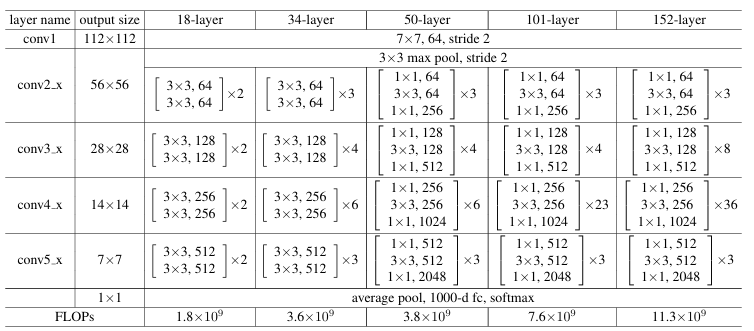

The initial weights used for the model are IMAGENET1K_V1, which were pre-trained on the ImageNet-1K dataset, same as ViT. Refer to the following figure for further details [6]:

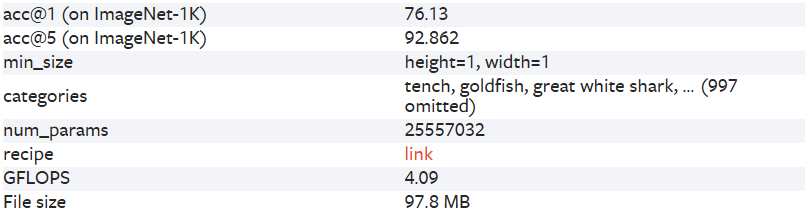

### 3.2.2 ResNet50 Training Evaluation

<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:1: SyntaxWarning: invalid escape sequence '\R'
C:\Users\dgoli\AppData\Local\Temp\ipykernel_33752\3846327973.py:1: SyntaxWarning: invalid escape sequence '\R'
  file_path = 'output\ResNet50_AUG.xlsx'


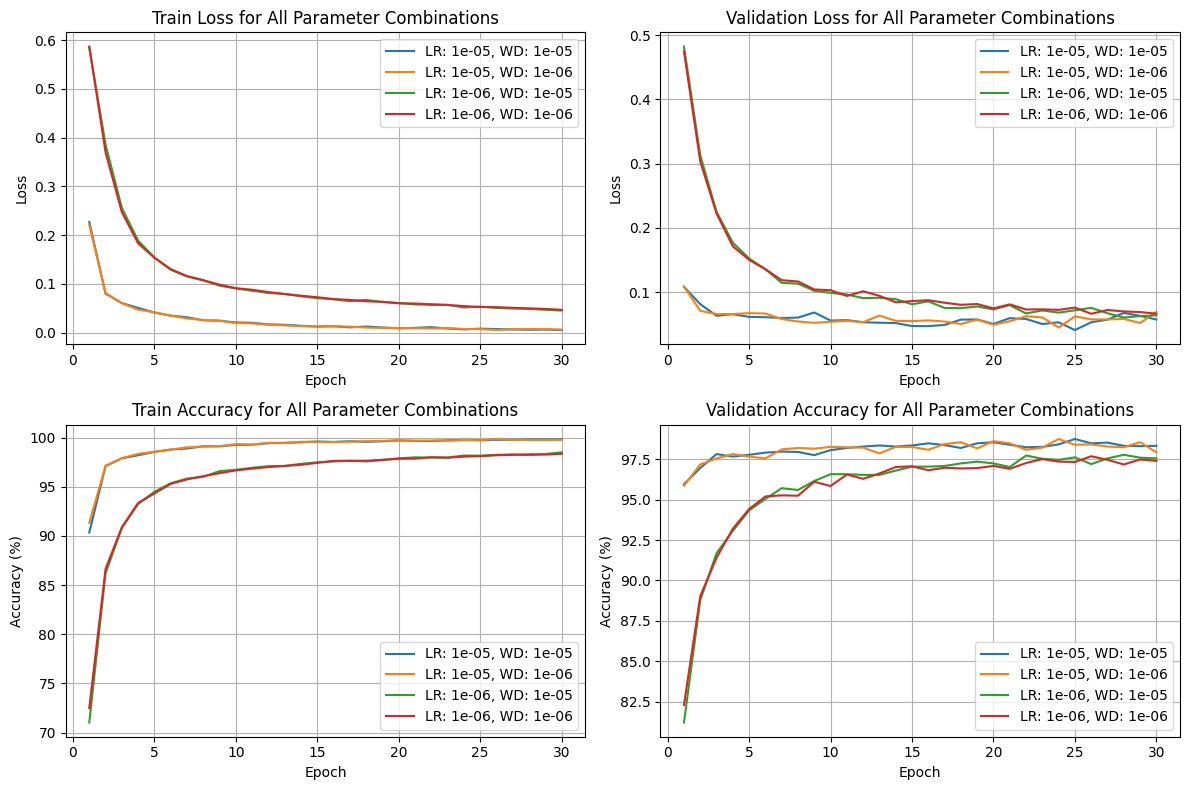

In [19]:
file_path = 'output\ResNet50_AUG.xlsx'  
plot_training_metrics(file_path)


The top 3 records with highest validation accuracy during training:
| Epoch | Learning Rate | Num Epochs | Weight Decay | Train Loss  | Train Accuracy | Validation Loss | Validation Accuracy |
|-------|---------------|------------|--------------|-------------|----------------|------------------|----------------------|
| 25    | 0.00001       | 30         | 0.00001      | 0.008060914 | 99.72345679    | 0.040920166      | 98.75555556          |
| 24    | 0.00001       | 30         | 0.000001     | 0.007267492 | 99.75555556    | 0.04485545       | 98.75555556          |
| 20    | 0.00001       | 30         | 0.000001     | 0.009429718 | 99.70864198    | 0.049242149      | 98.62222222          |


Under the same training parameters, ResNet-50 demonstrates a more stable convergence pattern compared to vit_b_16, with smoother and slower progress in both the training and validation stages. Throughout the 30 epochs, ResNet-50 exhibits a steady and continuous improvement in both metrics, unlike vit_b_16, where no observable improvement is seen in the training stage after 10 epochs and in validation accuracy after 15 epochs. 


However, similar to vit_b_16, ResNet-50 converges rapidly during the initial phase, with a significant drop in losses and a notable increase in accuracies within the first 5 epochs. ResNet-50 also shows more pronounced overfitting patterns when trained with a larger learning rate (1e-5) compared to a smaller one (1e-6). Despite the overfitting observed with 1e-5, ResNet-50 achieved higher accuracy on the validation set.

### 3.2.3 ResNet50 Testing Accuracy

In [18]:
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)
evaluate_model(model, "C:/ml/submit/best_model_Res50_AUG.pth", test_loader, device)



C:\Users\dgoli\AppData\Local\Temp\ipykernel_25580\1004073560.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Test Accuracy: 98.90%


98.9

## 3.3 EfficientNet - Narasipuram Siddhartha Mohan

### 3.3.1 Background

The specific model used was EfficientNetV2-M from the paper EfficientNetV2: Smaller Models and Faster Training by Tan and Le in 2021 [7]. The model was introduced as an improvement to the original EfficientNet (referred to as EfficientNetV1) by Tan and Le in 2020 [8]. EfficientNetV1 was inspired by MnasNet (Tan et al., 2019) [9], and the differentiating factor was the usage of floating point operations per second (FLOPs) as a reward parameter instead of the latency parameter of MnasNet. EfficientNetV1 was disadvantaged by the slow training times using images with large resolutions, early depthwise convolution layers (MBConv) were not fast, and the equal scaling of height, width, and image resolution across the different EfficientNet model versions was not optimal. EfficientNetV2 was implemented to counter these problems by implementing MBConv and fused-MBConv blocks, NAS search, intelligent model scaling, and progressive learning. EfficientNetV2 is structured as follows:

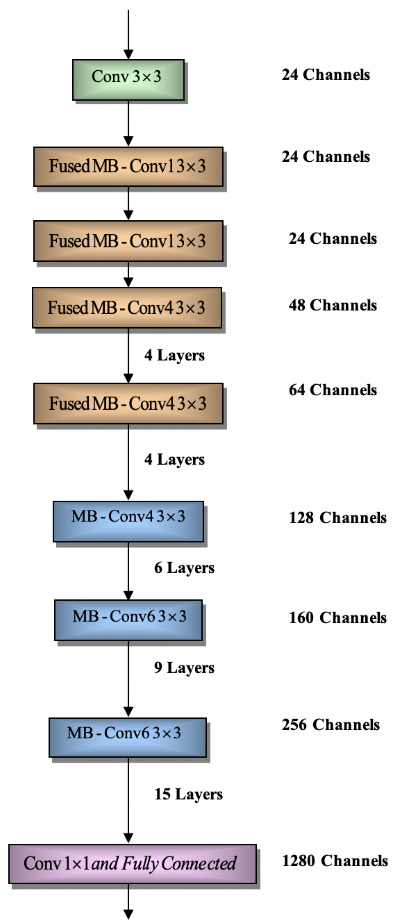 

EfficientNet Training With Simple Augmentations: 

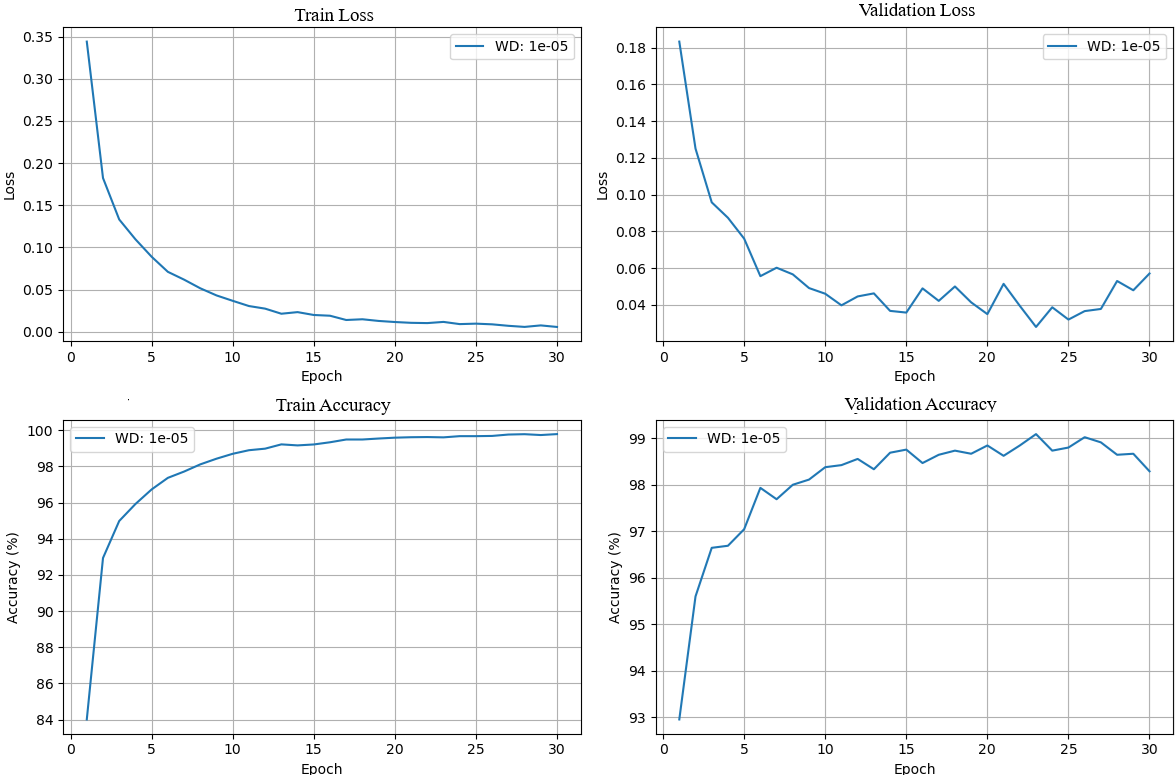

The top 3 records with highest validation accuracy during training:

| Epoch | Learning Rate | Num Epochs | Weight Decay | Train Loss | Train Accuracy | Validation Loss | Validation Accuracy |
| ----- | ------------- | ---------- | ------------ | ---------- | -------------- | --------------- | ------------------- |
| 23    | 0.00001       | 30         | 0.00001      | 0.011755   | 99.60988       | 0.027973        | 99.08889            |
| 26    | 0.00001       | 30         | 0.00001      | 0.008885   | 99.68889       | 0.036605        | 99.02222            |
| 27    | 0.00001       | 30         | 0.00001      | 0.007137   | 99.76543       | 0.037775        | 98.91111            | 


After training for 30 epochs, EfficientNetV2-m had a saved model with 99.8% validation accuracy at epoch 23 according to the results above. Although the acuracy is high,  epoch 23 was in the overfitting trend of the training graphs. The latter end of the training according the validation accuracy graph started to decline and the validation loss started to incline indicating ovberfitting, therefore resultign in the high accuracy.The validation curves were also very violent with consequent peaks and dips in the trend rather than a smooth curve. 

From this evaluation, the problems needed to be solved is the overfitting of the model and violent training curves.  

## 3.4 MobileNet - Narasipuram Siddhartha 

The specific model used was MobileNetV3_large from the paper, Searching for MobileNetV3, by  Howard et al [10]. MobileNetV3 adds squeeze and excitations layers in the initial block as built in MobileNetV2 [11]. MovileNetV3 is designed for efficient inference in movile and embedded devices, has a low memeory footprint and fast inference. Though because of its small nature it has reduced accuracy, limited complexity and faces difficultuu in handling large inputs. 

The structure of MobileNetV3 is built with a Convolutional Layers, downsampling and bottlenecks,  activation and pooling and output layer.

Structure of MobileNetv3:

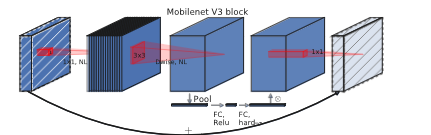

Initial testing is performed with the standard training loop and at 30 epochs with simple augmentations.

Graph 3.2 Training MobileNet

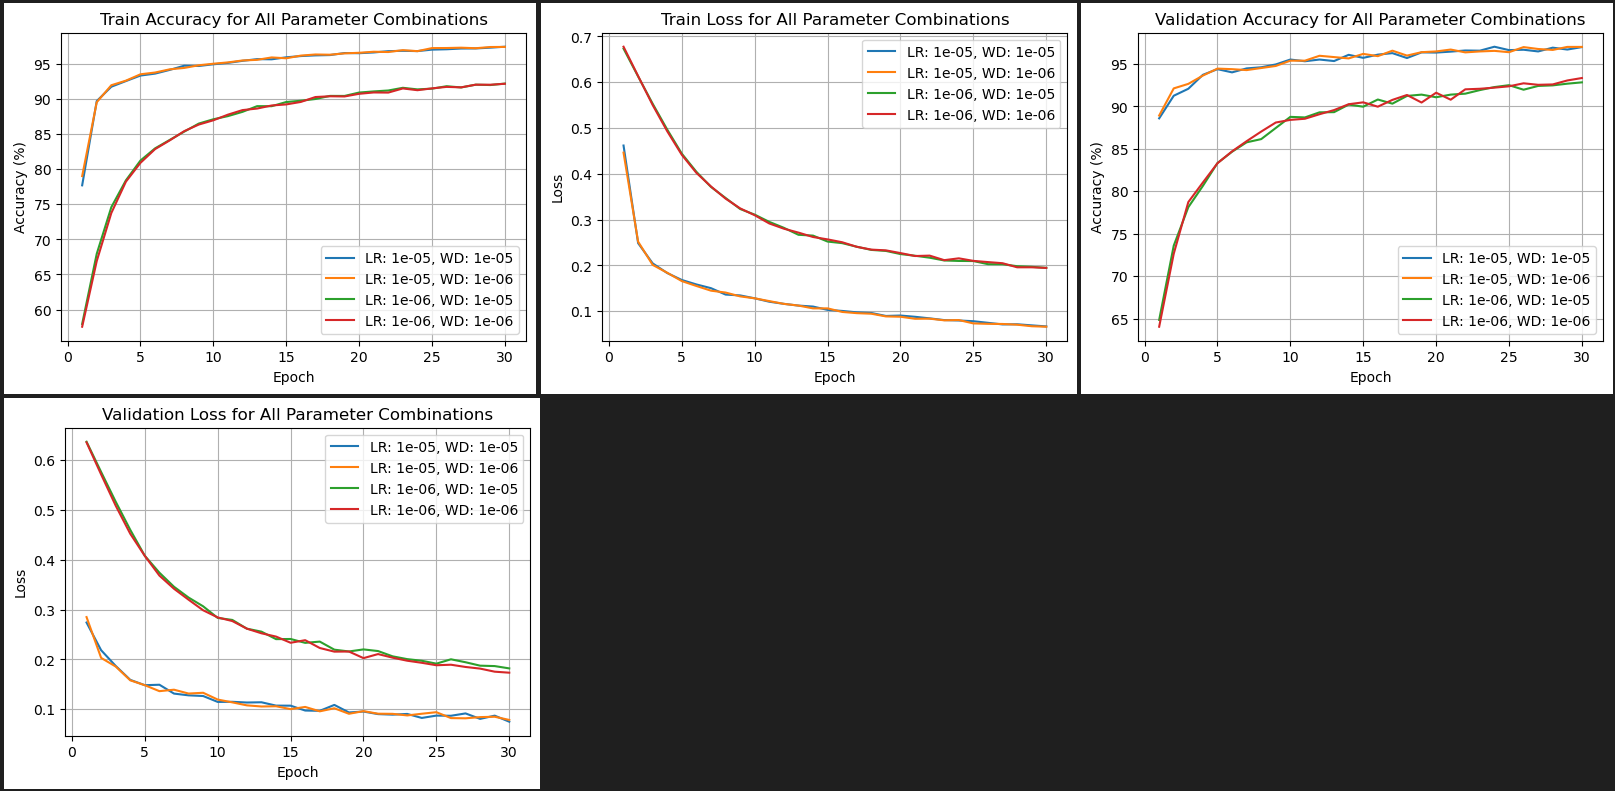

Table 3.2  Results of the Training 
| Epoch | Learning Rate | Num Epochs | Weight Decay | Train Loss | Train Accuracy | Validation Loss | Validation Accuracy |
| ----- | ------------- | ---------- | ------------ | ---------- | -------------- | --------------- | ------------------- |
| 24    | 0.00001       | 30         | 0.00001      | 0.079882   | 96.83704       | 0.08286         | 97.04444            |
| 29    | 0.00001       | 30         | 0.000001     | 0.067309   | 97.41975       | 0.085246        | 97.02222            |
| 30    | 0.00001       | 30         | 0.000001     | 0.066253   | 97.43457       | 0.078858        | 97.02222            |
| 30    | 0.00001       | 30         | 0.00001      | 0.066921   | 97.46173       | 0.075272        | 97                  |
| 26    | 0.00001       | 30         | 0.000001     | 0.072554   | 97.27654       | 0.082547        | 97                  |
| 28    | 0.00001       | 30         | 0.00001      | 0.071625   | 97.21481       | 0.080966        | 96.93333            |

From Graph  3.2 the curve is fairly smooth but it is still decreasing showing an opprtunity for further learning give more epochs.  According to Table 3.2, the best validation accuracy is 97.04 at epoch 24 with parameters 1e-05 learning rate and weight decay. The accuracy is slightly below the expected threshold of 98%. Further opportumities to improve the learning curve and teh accuracy should be explored. 

## 3.5 Phase 1 Conclusion and TA Test Case Results

From the above training evaluation, observation include: 
1. Models have demonstrated a better converging pattern with smaller learning rates (lr=1e-6). 
2. Models have demonstrated signs of overfitting.
3. Mmodels obtained higher accuracy are the ones with more serious overfitting signs.

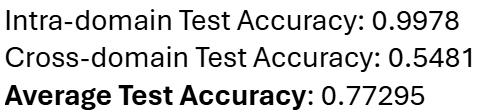


The reason behind observation 4 may be due to the nature of the provided dataset, which consists of real images and images generated by Stable Diffusion v1.4. As the models show signs of overfitting, they are also learning more and more of the generative characteristics of the Stable Diffusion model, resulting in higher validation accuracy even with overfitting. The intra-domain test result also supports this point, with an accuracy of 99.78%, highlighting the trained models' strong ability to capture Stable Diffusion model generated imagess. However, because the given dataset only consists of images generated by the Stable Diffusion model, the trained models have not seen AI-generated images from other sources, which resulting in extremely poor with only 54.81% accuracy. Therefore, it can be concluded that overfitting, along with the model's strong focus on capturing the characteristics of the Stable Diffusion model can result in overlooking images generated by other models.

# 4. Phase 2: Adjustments

## 4.1 Introduction

### 4.1.1 Phase 2 Strategy
Given that the models performs excellent in intra-domain test cases but poorly in Cross-domain test cases, normalization techniques are need to be performed during training to increase the models' generalization and gain abilit to classify Cross-domain test cases.



### 4.1.2 Phase 2 Image Augmentations

Since the only accessible datasets are Stable Diffusion-generated images and real-world images, more aggressive augmentations are incorporated, including transforms.RandomErasing, transforms.RandomAffine, and transforms.RandomRotation, to introduce additional variability into the training set. This aims to enable the model to generalize better across different types of generated images, with the hope of addressing the challenge of detecting cross-domain AI-generated images.

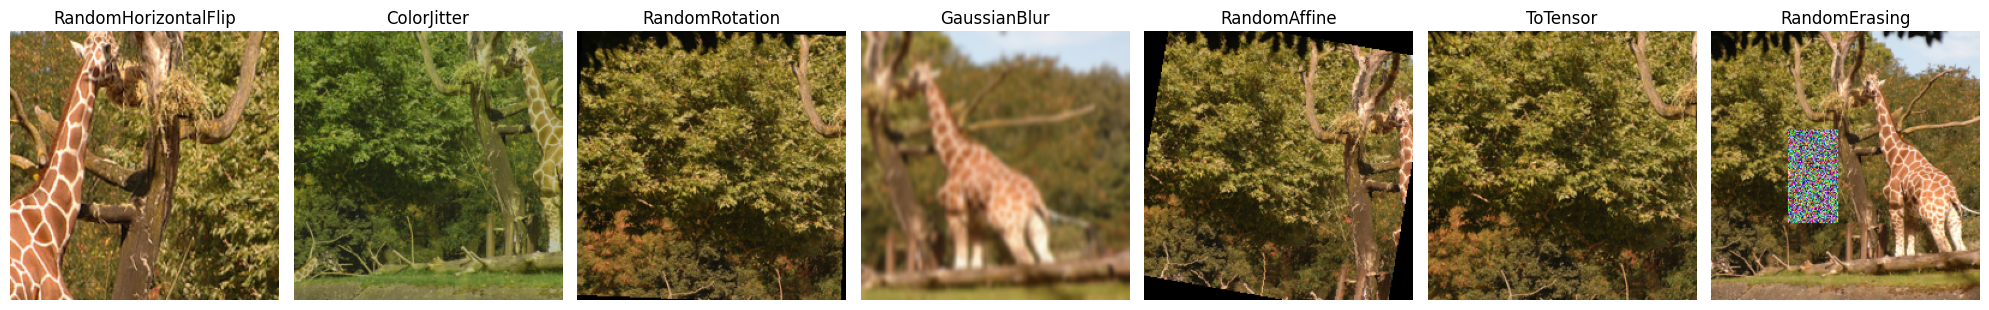

In [18]:
individual_transforms = [
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomAffine(degrees=10, scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),
]
random_crop = transforms.RandomResizedCrop(224)
image_path = 'AIGC-Detection-Dataset/train/0_real/000000000025.jpg'
original_image = Image.open(image_path).convert('RGB')
plt.figure(figsize=(20, 10))
for i, transform in enumerate(individual_transforms):
    cropped_image = random_crop(original_image)  
    if isinstance(transform, transforms.ToTensor):
        transformed_image = transform(cropped_image)
        transformed_image = transforms.ToPILImage()(transformed_image) 
    elif isinstance(transform, transforms.RandomErasing):
        tensor_image = transforms.ToTensor()(cropped_image)
        transformed_tensor = transform(tensor_image)
        transformed_image = transforms.ToPILImage()(transformed_tensor)
    else:
        transformed_image = transform(cropped_image)
    plt.subplot(1, len(individual_transforms), i + 1)
    plt.imshow(transformed_image)
    plt.title(f"{type(transform).__name__}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### 4.1.2 Phase 2 Common Implmentation: Cosine Annealing with Warm Restart
Cosine annealing is a learning rate scheduling technique in which the learning rate follows a cosine-shaped curve, starting high and gradually decreasing to a minimum value over a cycle. With the warm restart feature proposed by Loshchilov et al. [12], the learning rate periodically decreases and then resets back to its initial value, encouraging further exploration and helping to escape local optima. This approach aims to improve model performance during training.

## 4.2 ViT Adjustments - Twan Tsz Yin

### 4.2.1 ViT Normalization: Layer Freezing

To resolve overfitting in the ViT model and enhance its generalization capability to overcome the cross-domain bottleneck, the layer-freezing approach is employed. During the training process, weights in specified layers are kept unchanged (frozen) to avoid fine-tuning the pre-trained weights learned from ImageNet. 

In this adjustment, different portions of encoder blocks in the ViT will be frozen in a bottom-up approach, and their performance will be compared under the same parameters and settings for the task of detecting cross-domain AI-generated images. By freezing the lower layers, the model preserves the general, transferable features learned during pre-training (ImageNet), such as edges and textures, which are crucial for maintaining robustness across different domains. This allows the higher layers to focus on adapting to task-specific patterns, such as those unique to AI-generated images, thereby improving the model's ability to generalize while reducing the risk of overfitting. 

The following are the experimented freezing portions:
1. First 10% (1/12 layers)
2. First 30% (3/12 layers)
3. First 50% (6/12 layers)
4. First 70% (8/12 layers)


### 4.2.2 Normalized ViT Training Evaluation

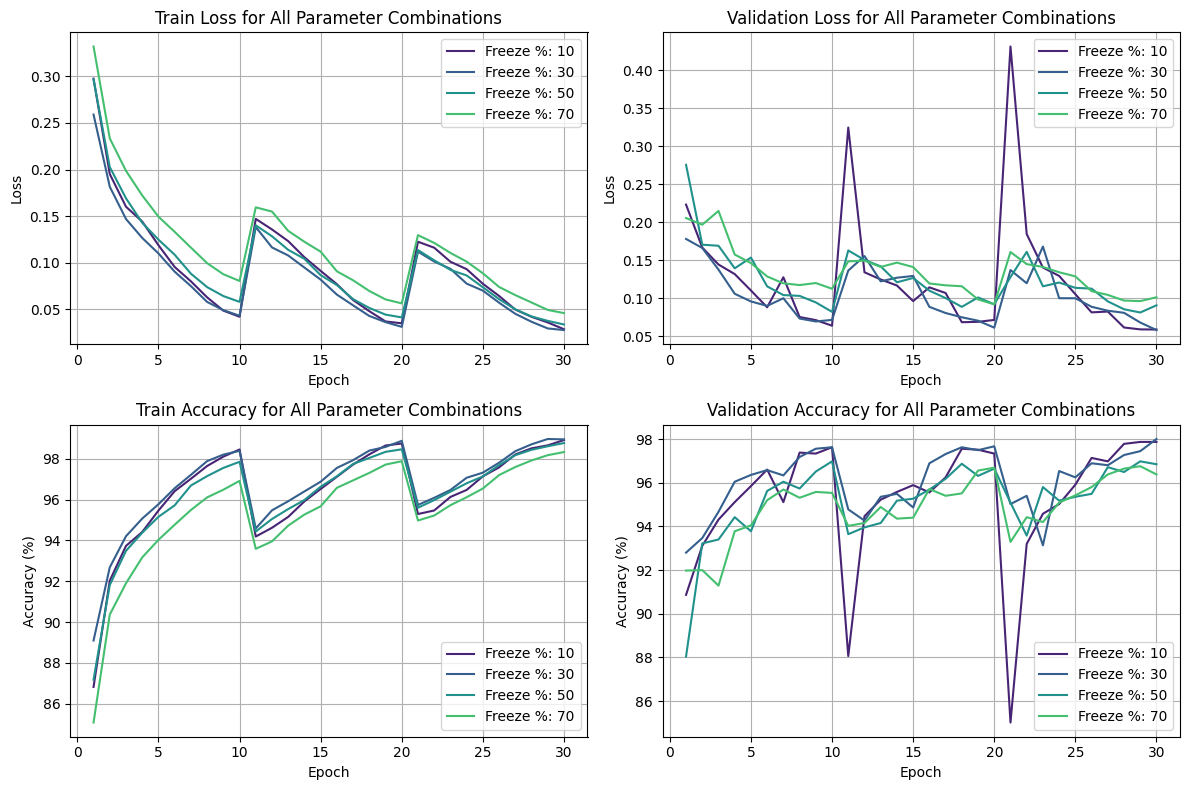

In [ ]:
file_path = 'output/vit_training_log_freeze_percentage_waemup.xlsx'  
plot_training_metrics(file_path,"freeze")


The top 3 records with highest validation accuracy during training:
| Epoch | Learning Rate | Num Epochs | Weight Decay | Freeze Percentage | Train Loss  | Train Accuracy | Validation Loss | Validation Accuracy |
|-------|---------------|------------|--------------|-------------------|-------------|----------------|-----------------|---------------------|
| 30    | 0.0001        | 30         | 0.00001      | 30                | 0.027742452 | 98.95555556    | 0.05832809      | 98                  |
| 29    | 2.54473E-06   | 30         | 0.00001      | 10                | 0.035909764 | 98.6617284     | 0.059208102     | 97.86666667         |
| 30    | 0.0001        | 30         | 0.00001      | 10                | 0.028598032 | 98.92098765    | 0.059008888     | 97.86666667         |




The validation accuracy before learning rate restart during training:
| Freeze Percentage | Learning Rate | Validation Accuracy (Epoch 10) | Validation Accuracy (Epoch 20) | 1st Restart Improvement (%) | Validation Accuracy (Epoch 30) | 2nd Restart Improvement (%) | Overall Improvement (%) |
|--------------------|---------------|--------------------------------|--------------------------------|-----------------------------|--------------------------------|-----------------------------|--------------------------|
| 10                 | 0.0001        | 97.622                        | 97.333                        | -0.289                     | 97.867                        | 0.533                      | 0.244                   |
| 30                 | 0.0001        | 97.622                        | 97.667                        | 0.044                      | 98.000                        | 0.333                      | 0.378                   |
| 50                 | 0.0001        | 96.978                        | 96.644                        | -0.333                     | 96.844                        | 0.200                      | -0.133                  |
| 70                 | 0.0001        | 95.533                        | 96.689                        | 1.156                      | 96.378                        | -0.311                     | 0.844                   |



From the graphs, the effects of implementing a cosine annealing with a warm restart scheduler are significant, with clear spikes in performance at every warm restart cycle, followed by gradual convergence. In most restart cycle, the ViT model was able to reach a new peak in training and validation accuracy and a new low in training and validation loss, demonstrating the capability of cosine annealing with warm restarts to effectively help the model escape local optima, explore better solutions in the loss landscape, and improve performance under layer-freezing conditions.

### 4.2.3 ViT Test Accuracy

In [6]:
model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
model.heads.head = nn.Linear(model.heads.head.in_features, 2)
evaluate_model(model, "best_model_vit_freeze_30.pth", test_loader, device)


C:\Users\dgoli\AppData\Local\Temp\ipykernel_4048\2699319519.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Test Accuracy: 97.80%


97.8

## 4.3 ResNet50 Adjustments -Twan Tsz Yin


### 4.3.1 ResNet50 Normalization Approach

For ResNet50 adjustment, it adopted a different normalization strategy compared to vit_b_16 by using dropout as a regularization technique during training rather than layer freezing. The purpose of taking a different approach for regularizing ResNet50 is to practice different normalization techniques and also to explore how various normalization methods may result in capturing different features in the data.


Dropout helps prevent overfitting by randomly deactivating a fraction of neurons in a layer during each forward pass, forcing the model to learn more distributed and generalized feature representations. The dropout of ResNet50 in this project is achieved by replacing the fully connected layer of ResNet50 with a sequential block that includes a dropout layer and a linear classification layer. 

Also, since vit_b_16 has demonstrated positive results in the previous experiment with a fixed restart cycle of 10 epochs, the training process of ResNet-50 will explore the effectiveness of applying different restart cycles.

The following are the experimented parameter combinations:
1. Dropout rate = 0.3, restart cycle = 5
2. Dropout rate = 0.5, restart cycle = 10
3. Dropout rate = 0.3, restart cycle = 5
4. Dropout rate = 0.5, restart cycle = 10



### 4.3.2 Normalized ResNet50 Training Evaluation

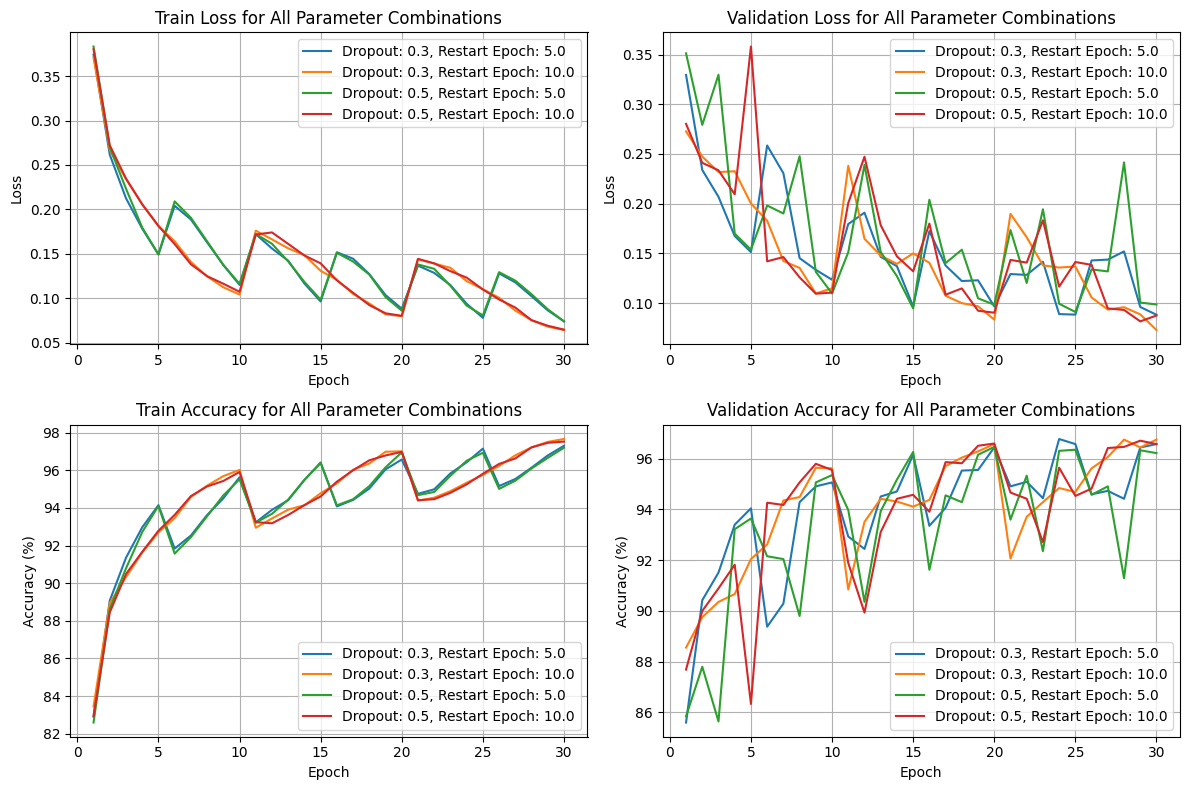

In [9]:
file_path = 'output/ResNet50_dropout_warnrestart_final2.xlsx'  
plot_training_metrics(file_path,"resnet")

The top 3 records with highest validation accuracy during training:
| Epoch | Learning Rate | Num Epochs | Weight Decay | Dropout Rate | Restart Epoch | Train Loss   | Train Accuracy  | Validation Loss | Validation Accuracy |
|-------|---------------|------------|--------------|--------------|---------------|--------------|-----------------|-----------------|---------------------|
| 24    | 9.54915E-06   | 30         | 0.00001      | 0.3          | 5             | 0.093729184  | 96.42222222     | 0.0890031       | 96.77777778         |
| 28    | 9.54915E-06   | 30         | 0.00001      | 0.3          | 10            | 0.075114341  | 97.21481481     | 0.095887879     | 96.75555556         |
| 30    | 0.0001        | 30         | 0.00001      | 0.3          | 10            | 0.064110336  | 97.65925926     | 0.072961664     | 96.75555556         |

Restart frequency evaluation:
| Restart Epoch | Dropout Rate | Improvement (1st restart, %) | Improvement (2nd restart, %) | Improvement (3rd restart, %) | Improvement (4th restart, %) | Improvement (5th restart, %) | Overall Improvement | Average Restart Improvement |
|---------------|--------------|-----------------------------|-----------------------------|-----------------------------|-----------------------------|-----------------------------|---------------------|-----------------------------|
| 5             | 0.3          | 1.0222                     | 1.0889                     | 0.2889                     | 0.1333                     | 0.0000                     | 2.5333              | 0.5067                      |
| 5             | 0.5          | 1.7111                     | 0.9111                     | 0.2000                     | -0.1111                    | -0.1333                    | 2.5778              | 0.5156                      |
| 10            | 0.3          | 0.9556                     | 0.1778                     | N/A                        | N/A                        | N/A                        | 1.1333              | 0.5667                      |
| 10            | 0.5          | 1.0444                     | -0.0222                    | N/A                        | N/A                        | N/A                        | 1.0222              | 0.5111                      |




By observation, the warm restart frequency of cosine annealing does not significantly differentiate the outcome under 30 epochs, even though the restart frequency of 5 epochs per cycle has doubled compared to a 10-epoch cycle. This could be because the total number of epochs is insufficient for the varying restart frequencies to fully exploit their potential differences in learning dynamics, resulting in similar overall performance.

The main factor that differentiates the validation accuracy is the dropout rate, where under all restart frequencies, a higher dropout rate of 0.5 consistently outperforms the lower dropout rate of 0.3. One potential reason behind this is that a higher dropout rate introduces more regularization, preventing overfitting and encouraging the model to learn more robust and generalized features.

### 4.3.3 ResNet50 Test Accuracy

In [ ]:
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)
evaluate_model(model, "best_model_Res50_AUG_dropout_0.3_T0_5_2.pth", test_loader, device,"dropout")

C:\Users\dgoli\AppData\Local\Temp\ipykernel_29420\2699319519.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Test Accuracy: 99.02%


99.02

## 4.4 EfficientNet


### 4.4.1 Early Stoppping

In Phase 1 evaluation,  we saw that the graph started to overfit as there was a rise in the validation loss in the latter end of the training.  In order to counter this phenomenon, we decided to implemnent early stopping in order to pause the training when we havent seen an improvement in terms of the validation accuracy by implementing a patience threshold.

As 1e-5 was the best performing weight decay and learning rate parameter,  we used it to gauge the effect of early stopping in the training process.


Training EfficientNet with Early Stopping: 

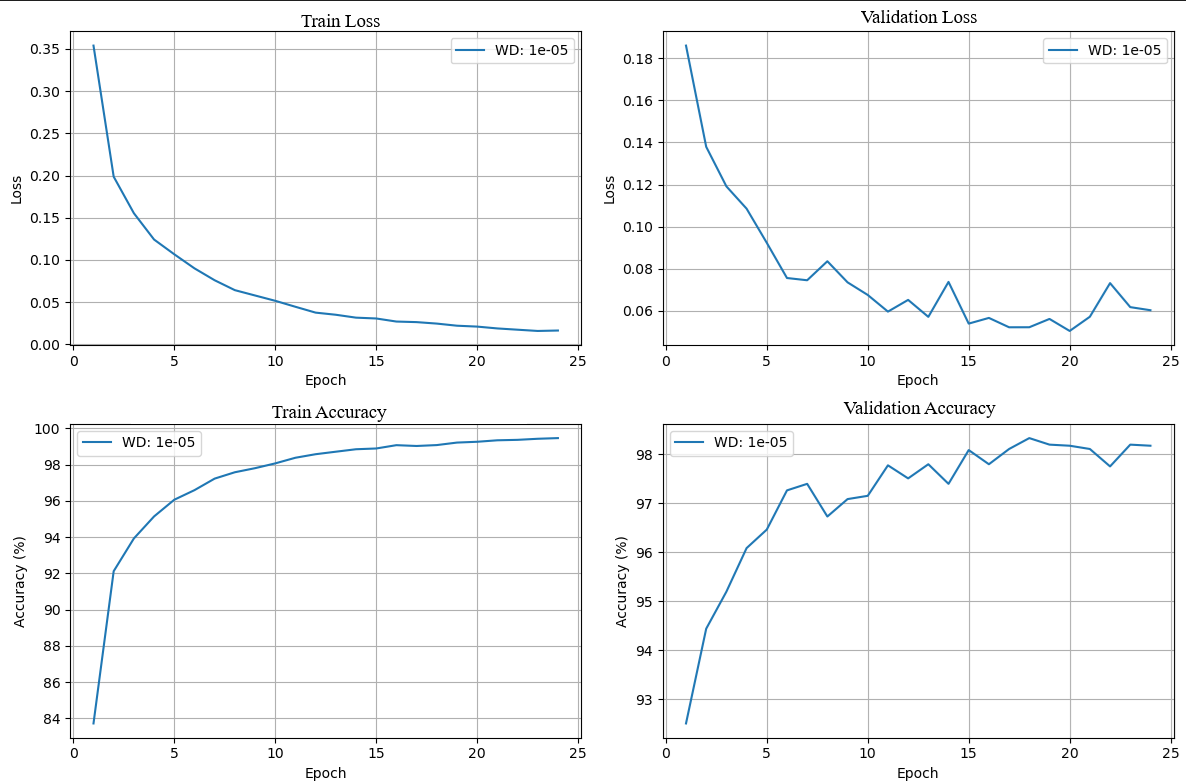


Training With Early Stopping:

| Epoch | Learning Rate | Num Epochs | Weight Decay | Train Loss | Train Accuracy | Validation Loss | Validation Accuracy |
| ----- | ------------- | ---------- | ------------ | ---------- | -------------- | --------------- | ------------------- |
| 18    | 0.00001       | 30         | 0.00001      | 0.024716   | 99.0716        | 0.052203        | 98.33333            |
| 19    | 0.00001       | 30         | 0.00001      | 0.022206   | 99.20988       | 0.056155        | 98.2                |
| 23    | 0.00001       | 30         | 0.00001      | 0.015994   | 99.41975       | 0.06176         | 98.2                |


By comparing the above results of EfficientNet with the previous ones in the Phase 1,  we can see that without early the graph proceeds to train untill the  full 30 epoch completion and starts to overfit at the end with the model being saved at epoch 23 with 99.08% accuracy. After implementing early stopping, training is halted at epoch 24, rather than the full 30 epochs, and the model was saved at epoch 18  with the validation accuracy being 98.33% at the plateau of the training curce. Although the accuracy for training with early stopping is slightly worse than without early stopping,  it goes to show that the model is more generalized.

Early stopping has proven to save models before the model starts to overfit, and will therefore be further used in the enhancement of the EfficicentNet training.

### 4.4.2 Cosine Annealing Learning Rates

After solving the overfitting issue,  the remaining enhancement is to smoothen the validation curve from its aforeseen violent discrepencies in the trend. To do so, we will utlilize cosine annealing with warm restarts as we need to stabilize the training and require better generalization. Pytorch's coosinCosineAnnealingWarmRestarts function will be used. The parameters for the cosine annealing is T_0 which is the number of iterations before restarting and T_mult which is the factor T_0 is multiplied before restarting. Since we are only working with 30 epochs and the results in section 4.2.1 show that the deiscrepancies start at the 8th epoch, a T_0 value of 3 is chosen with a T_mul value of 2 so that the model can train at high learning rates in the beginning a lower learning rate as the training goes on. 

EfficientNet Training with Cosine Annealing Learning Rate and Early Stopping:

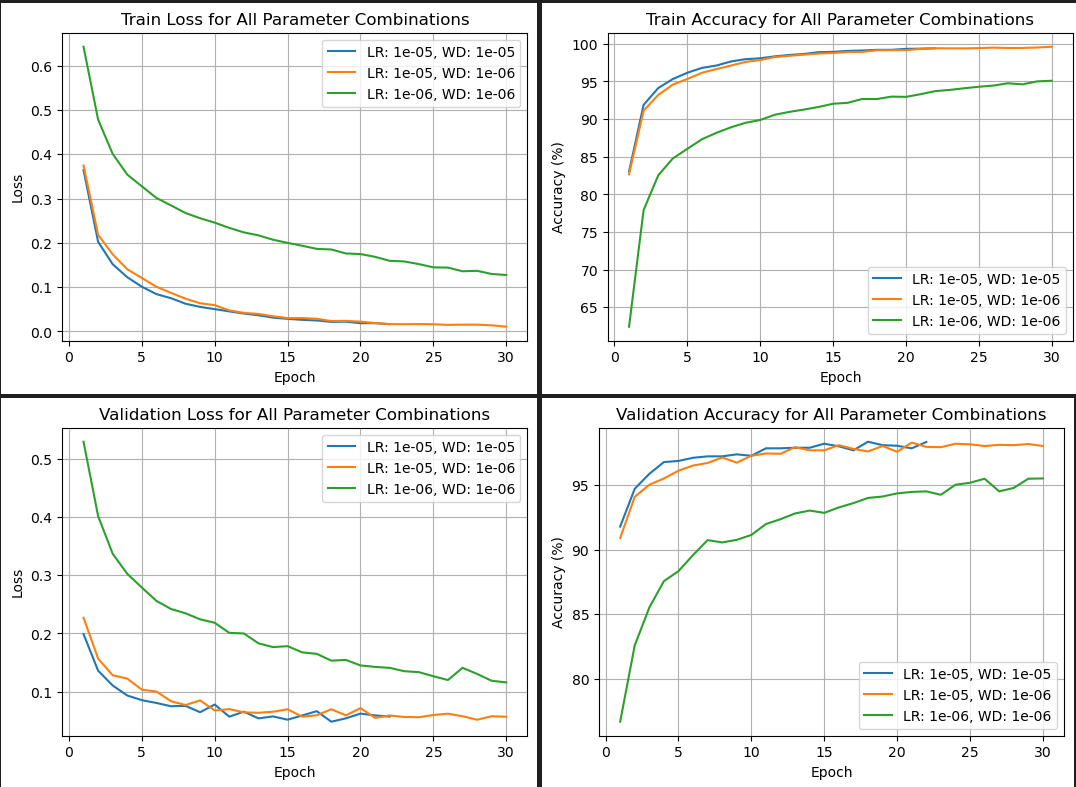


The top 3 records with highest validation accuracy during training:

| Epoch | Learning Rate | Num Epochs | Weight Decay | Train Loss | Train Accuracy | Validation Loss | Validation Accuracy |
| ----- | ------------- | ---------- | ------------ | ---------- | -------------- | --------------- | ------------------- |
| 18    | 0.00001       | 30         | 0.00001      | 0.021687   | 99.2           | 0.048247        | 98.35556            |
| 22    | 0.00001       | 30         | 0.00001      | 0.016407   | 99.40494       | 0.057119        | 98.33333            |
| 21    | 0.00001       | 30         | 0.000001     | 0.018959   | 99.32593       | 0.054894        | 98.28889            |

According to the training and validation graphs above, the training curve in the validation accuracy and loss graphs is much smoother compared to EfficientNet without Cosine Annealing Warm Restarts applied. Although there are some slight consecutive discrepancies, the amplitude of these discrepancies is much smaller. The model was saved with the best parameters, where the learning rate and weight decay were set to 1e-05, achieving a validation accuracy of 98.35%. While there is a slight improvement in the saved model compared to training with only early stopping, it still falls short of the 99.08% accuracy from Phase 1. Further enhancements to improve accuracy will be explored.

## 4.5 MobileNet

### 4.5.1 Training with 60 Epochs 

From the previous training results of MobileNet, we see that the learining curve for the validation loss is still declining and the accuracy is still increasing,  therefore it was suggested to fully explore the learnining capabilities of the MobileNet model by doubling the trianing time and training for 60 epochs. 

MobileNet Training with 60 Epochs:

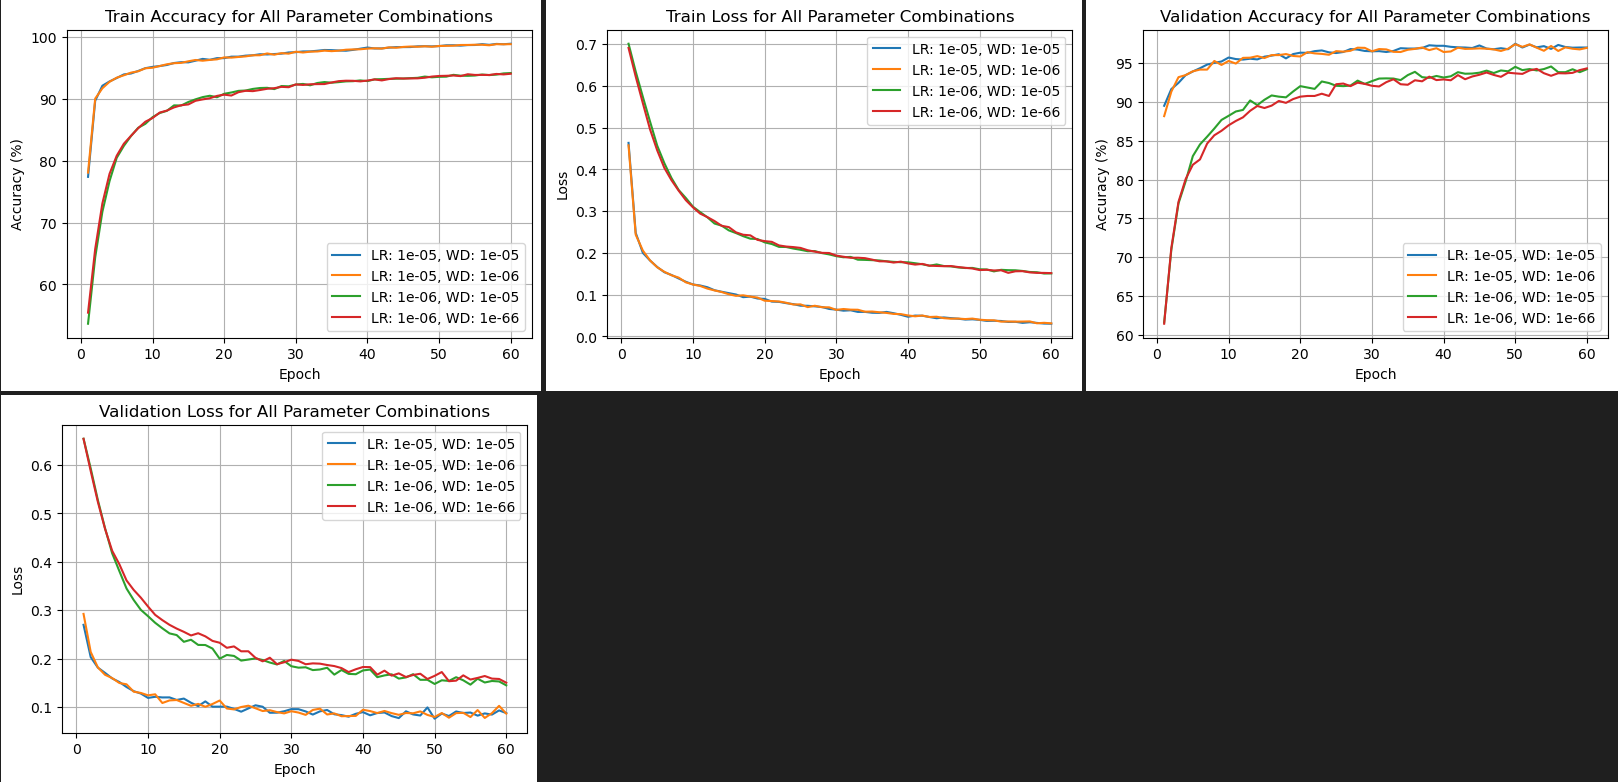

The top 3 records with highest validation accuracy during training:

| Epoch | Learning Rate | Num Epochs | Weight Decay | Train Loss | Train Accuracy | Validation Loss | Validation Accuracy |
| ----- | ------------- | ---------- | ------------ | ---------- | -------------- | --------------- | ------------------- |
| 50    | 0.00001       | 60         | 0.00001      | 0.039657   | 98.49136       | 0.07545         | 97.51111            |
| 50    | 0.00001       | 60         | 0.000001     | 0.040024   | 98.51111       | 0.079137        | 97.44444            |
| 52    | 0.00001       | 60         | 0.000001     | 0.038652   | 98.55802       | 0.077542        | 97.42222            |


From generated graphs above for MoiblieNet, the curve is fairly logarrithmic and is slightly turbulent. The latter part of the training has plateued indicating that the model is fully trained and further training could result in overfitting.  Accorfing to the top results of MobileNet withearly stopping, the model was saved with parameters 1e-05 learning rate and weight decay with 97.51 validation loss. 

As an accuracy of at least 98% would be desirable, further measures for increasing accuracy will be explored.

### 4.5.2 Layer Freezing

We decided to utlilize the layer freezing technique commonly used in transfer learning approaches as it has show to better generalize features in shared domain learning. We will first compare the validation accuracy of freezing 10, 30, 50  and 70 percent from the beginning of the model  at 10 epochs each. After finding the freezing percentage with the best accuracy we will proceed to fully train it on 60 epochs

We have chosen to continue only using the 1e-5 learning rate and weight decay parameters as it has  show better results in the prior approachs. 

Results of freezing different percentage of layers of MobileNet:
| Epoch | Learning Rate | Num Epochs | Weight Decay | Freeze | Train Loss | Train Accuracy | Validation Loss | Validation Accuracy |
| ----- | ------------- | ---------- | ------------ | ------ | ---------- | -------------- | --------------- | ------------------- |
| 10    | 0.00001       | 10         | 0.00001      | 10     | 0.127579   | 94.9679        | 0.122448        | 95.53333            |
| 9     | 0.00001       | 10         | 0.00001      | 10     | 0.136896   | 94.58765       | 0.12917         | 94.77778            |
| 8     | 0.00001       | 10         | 0.00001      | 10     | 0.145892   | 94.19012       | 0.138736        | 94.44444            |
| 10    | 0.00001       | 10         | 0.00001      | 30     | 0.139944   | 94.62963       | 0.144088        | 94.4                |
| 8     | 0.00001       | 10         | 0.00001      | 30     | 0.152414   | 94.02222       | 0.143724        | 94.22222            |
| 7     | 0.00001       | 10         | 0.00001      | 10     | 0.152601   | 93.86667       | 0.145472        | 94.2                |
| 9     | 0.00001       | 10         | 0.00001      | 30     | 0.149717   | 94.14815       | 0.143508        | 94.2                |
| 10    | 0.00001       | 10         | 0.00001      | 50     | 0.151697   | 93.96543       | 0.150791        | 94.2                |
| 8     | 0.00001       | 10         | 0.00001      | 50     | 0.165166   | 93.40741       | 0.157964        | 94.08889            |
| 7     | 0.00001       | 10         | 0.00001      | 30     | 0.159906   | 93.65432       | 0.152477        | 93.97778            |
| 7     | 0.00001       | 10         | 0.00001      | 50     | 0.172776   | 93.13827       | 0.154009        | 93.73333            |
| 9     | 0.00001       | 10         | 0.00001      | 50     | 0.158779   | 93.68642       | 0.153985        | 93.73333            |

From above table,  we see that freezing at 10% of its layers perfroms the best compared to the other percentages. The model at 10% freezing will now be fully trained till 60 epochs. 

The top 3 records with highest validation accuracy during MobileNet training with 10% Layers Frozen until 60 epochs: 

| Epoch | Learning Rate | Num Epochs | Weight Decay | Freeze | Train Loss | Train Accuracy | Validation Loss | Validation Accuracy |
| ----- | ------------- | ---------- | ------------ | ------ | ---------- | -------------- | --------------- | ------------------- |
| 43    | 0.00001       | 60         | 0.00001      | 10     | 0.052413   | 98.08889       | 0.031793        | 98.91111            |
| 55    | 0.00001       | 60         | 0.00001      | 10     | 0.037366   | 98.65679       | 0.034741        | 98.8                |
| 46    | 0.00001       | 60         | 0.00001      | 10     | 0.049416   | 98.16296       | 0.033031        | 98.77778            |


## 4.6 2nd & 3rd TA Test Results

The results of TA's accuracy test (2nd attempt):

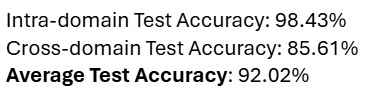

This is the first attempt after the models were normalized, where the cross-domain test accuracy increased significantly from 54.81% to 85.61%, indicating that the normalization approaches implemented during the model training process have been effective in improving the model's ability to generalize.

The results of TA's accuracy test (3rd attempt):

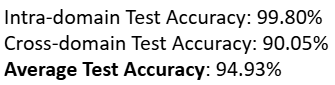

This is the second attempt after the models were normalized, where the initial learning rate for the warm restart was increased to a higher value (1e-4, compared to the original 1e-5). Both intra-domain and cross-domain accuracy have improved, suggesting that the higher initial learning rate helped the models escape local optima, thereby achieving better generalization.

## 4.7 Phase 2 Conclusion

By comparing the results of the second and third test attempts with the first, an observation can be made that normalizing the models in terms of structure-wise normalization (e.g., layer freezing, dropout) and input normalization (e.g., aggressive image augmentations) can significantly improve the generalization of the model, gaining the capability to capture a more generalized set of features that are invariant to specific domain characteristics. Therefore, this helps the models learn more robust representations that perform better across different domains, reducing overfitting and increasing cross-domain test accuracy.

# 5. Final Conclusion

This project has highlighted a critical challenge in AI-generated image detection using neural networks: the limited diversity of available datasets. Overfitting to a narrow dataset, as observed in Phase 1, proved ineffective in distinguishing AI-generated images from those produced by unknown models, resulting in low accuracy when encountering such cases. Additionally, the rapid development of generative models and the introduction of new architectures are making the detection task increasingly complex. These advancements introduce novel generative characteristics that further complicate detection.

However, by applying normalization techniques such as layer freezing, dropout, and aggressive data augmentation, significant improvements in cross-domain generalization were achieved. These methods helped prevent overfitting, enhanced model robustness, and improved the ability to distinguish AI-generated images from photographic images. This underscores the importance of normalization and the need for robust models that can adapt to evolving model architectures and effectively handle unseen generative variations.

# 6. Embedded Rersult (Submission)

In [ ]:

class ResNet50WithDropout(nn.Module):
    def __init__(self, dropout_rate=0.3): 
        super(ResNet50WithDropout, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, 2)  
        )
    def forward(self, x):
        return self.resnet(x)
    


def test(test_dataset_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),  
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    ])
    test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    model_configs = [
        ("resnet50", "output/bestResNet.pth", 0.2516),
        ("vit_b_16", "output/bestViT.pth", 0.2472),
        ("efficentnetv2_m","output/bestEfficientNet.pth",0.2516),
        ("mobilenetv3_large","output/bestMoveNet.pth",0.2502)
    ]

    def load_model(model_name, weight_path):
        if model_name == "resnet50":
            model = ResNet50WithDropout(dropout_rate=0.3)  
        elif model_name == "vit_b_16":
            model = models.vit_b_16(pretrained=False)
            model.heads.head = nn.Linear(model.heads.head.in_features, 2)
        elif model_name == "efficentnetv2_m":
            model = efficientnet_v2_m(pretrained=False) 
            model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
        elif model_name == "mobilenetv3_large":
            model = mobilenet_v3_large(pretrained=False)
            model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
        else:
            raise ValueError(f"Unsupported model: {model_name}")
        state_dict = torch.load(weight_path, map_location="cpu")
        model.load_state_dict(state_dict)
        return model

    models_with_weights = []
    for model_name, weight_path, weight in model_configs:
        model = load_model(model_name, weight_path)
        model.to(device)
        model.eval()
        models_with_weights.append((model, weight))
    y_true = []
    y_pred = []
    with torch.no_grad():
        for img, label in test_loader:
            img = img.to(device)
            combined_output = 0
            for model, weight in models_with_weights:
                output = model(img)
                combined_output += weight * F.softmax(output, dim=1)
            pred = torch.argmax(combined_output, dim=1).item()
            y_true.append(label.item())
            y_pred.append(pred)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    Accuracy = metrics.accuracy_score(y_true, y_pred)
    print(f"Accuracy: {Accuracy:.2%}")
    return Accuracy, y_true, y_pred

if __name__ == "__main__":
    test_dataset_path = "C:/ml/AIGC-Detection-Dataset/val" # Replace test dataset path
    Accuracy, y_true, y_pred = test(test_dataset_path)


Using device: cuda


c:\Users\dgoli\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dgoli\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\dgoli\AppData\Local\Temp\ipykernel_4048\1478504968.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flip

Accuracy: 98.78%


# 7. References

1. Y. Cao, S. Li, Y. Liu, Z. Yan, Y. Dai, P. S. Yu, and L. Sun, "A Comprehensive Survey of AI-Generated Content (AIGC): A History of Generative AI from GAN to ChatGPT," arXiv preprint, arXiv:2303.04226, Mar. 2023. [Online]. Available: https://doi.org/10.48550/arXiv.2303.04226.

2. A. Pocol, L. Istead, S. Siu, S. Mokhtari, and S. Kodeiri, "Seeing Is No Longer Believing: A Survey on the State of Deepfakes, AI-Generated Humans, and Other Nonveridical Media," in Advances in Computer Graphics, B. Sheng, L. Bi, J. Kim, N. Magnenat-Thalmann, and D. Thalmann, Eds., Cham: Springer Nature Switzerland, 2024, pp. 427–440. [Online]. Available: https://doi.org/10.1007/978-3-031-50072-5_34.

3. A. Vaswani, N. Shazeer, N. Parmar, J. Uszkoreit, L. Jones, A. N. Gomez, L. Kaiser, and I. Polosukhin, "Attention Is All You Need," arXiv preprint, arXiv:1706.03762, Aug. 2023. [Online]. Available: https://arxiv.org/abs/1706.03762.

4. "ViT_B_16 Model," PyTorch Vision, [Online]. Available: https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html.

5. K. He, X. Zhang, S. Ren, and J. Sun, "Deep Residual Learning for Image Recognition," arXiv preprint, arXiv:1512.03385, Dec. 2015. [Online]. Available: https://arxiv.org/abs/1512.03385.

6. "ResNet-50 Model Documentation," PyTorch, [Online]. Available: https://pytorch.org/vision/0.18/models/generated/torchvision.models.resnet50.html.

7. M. Tan and Q. V. Le, "EfficientNetV2: Smaller Models and Faster Training," Proc. of the International Conference on Machine Learning (ICML), 2021. Available: https://arxiv.org/abs/2104.00298.

8. M. Tan and Q. V. Le, "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks," Proc. of the International Conference on Machine Learning (ICML), 2020. Available: https://arxiv.org/abs/1905.11946.

9. M. Tan, Q. V. Le, and others, "MnasNet: Platform-Aware Neural Architecture Search for Mobile," Proc. of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), 2019. Available: https://arxiv.org/abs/1807.11626.

10. M. Sandler, A. Howard, M. Zhu, A. Zhmoginov, and L.-C. Chen, “MobileNetV2: Inverted Residuals and Linear Bottlenecks,” Mar. 21, 2019, arXiv: arXiv:1801.04381. doi: 10.48550/arXiv.1801.04381.
11. A. Howard et al., “Searching for MobileNetV3,” Nov. 20, 2019, arXiv: arXiv:1905.02244. doi: 10.48550/arXiv.1905.02244.

12. Loshchilov and F. Hutter, "SGDR: Stochastic Gradient Descent with Warm Restarts," arXiv preprint, arXiv:1608.03983, May 2017. [Online]. Available: https://arxiv.org/abs/1608.03983.

# 8. Training Code

## 8.1.1 Setup

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=10, scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


data_dir = "C:/ml/AIGC-Detection-Dataset" # Training dataset
full_train_dataset = ImageFolder(root=f'{data_dir}/train', transform=transform)
train_num = 0.9
val_num = 1 - train_num
train_size = int(train_num * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = ImageFolder(root=f'{data_dir}/val', transform=test_transform)
class_names = full_train_dataset.classes
print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Testing samples: {len(test_dataset)}')
print(f'Classes: {class_names}')
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
num_classes = len(class_names)
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

Training samples: 40500
Validation samples: 4500
Testing samples: 5000
Classes: ['0_real', '1_fake']


## 8.2 Training code for ViT (LayerFreezing+CosineAnnealingWithWarmRestart)

In [7]:
learning_rates = [1e-4]
num_epochs_list = [1]
weight_decays = [1e-5]
layer_freeze =  [10, 30, 50, 70]

param_combinations = [(lr, num_epochs, wd) for lr, num_epochs, wd in zip(learning_rates, num_epochs_list, weight_decays)]


def freeze_percentage_of_layers(model, percentage):
    total_layers = len(model.encoder.layers)
    layers_to_freeze = int(total_layers * (percentage / 100))
    print(f"Freezing {layers_to_freeze}/{total_layers} layers ({percentage}%).")
    for i in range(layers_to_freeze):
        for param in model.encoder.layers[i].parameters():
            param.requires_grad = False

best_val_acc = 0.0
best_hyperparams = None
best_epoch = None
log_entries = []
all_epoch_metrics = []
for lr, num_epochs, weight_decay in param_combinations:
    print(f"\nTraining with LR={lr}, Epochs={num_epochs}, Weight Decay={weight_decay}")
    for freeze_percentage in layer_freeze:
        print(f"\nTraining with Freeze Percentage={freeze_percentage}%...")
        model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
        model.to(device)
        freeze_percentage_of_layers(model, percentage=freeze_percentage)
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-7)
        criterion = nn.CrossEntropyLoss()
        epoch_metrics = []
        for epoch in range(num_epochs):
            print(f"Starting Epoch {epoch + 1}/{num_epochs}...")
            model.train()
            correct_train = 0
            total_train = 0
            running_train_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
            train_accuracy = 100 * correct_train / total_train
            avg_train_loss = running_train_loss / total_train
            model.eval()
            correct_val = 0
            total_val = 0
            running_val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
            val_accuracy = 100 * correct_val / total_val
            avg_val_loss = running_val_loss / total_val
            scheduler.step()
            epoch_metric = {
                'Epoch': epoch + 1,
                'Learning Rate': scheduler.get_last_lr()[0],
                'Num Epochs': num_epochs,
                'Weight Decay': weight_decay,
                'Freeze Percentage': freeze_percentage,
                'Train Loss': avg_train_loss,
                'Train Accuracy': train_accuracy,
                'Validation Loss': avg_val_loss,
                'Validation Accuracy': val_accuracy,
            }
            epoch_metrics.append(epoch_metric)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Current LR: {scheduler.get_last_lr()[0]:.8f}")
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                best_hyperparams = (lr, num_epochs, weight_decay, freeze_percentage)
                best_epoch = epoch + 1
                best_model_path = os.path.join(output_dir, f"bestViT.pth")
                torch.save(model.state_dict(), best_model_path)
                print(f"New best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}. Model saved.")
        all_epoch_metrics.extend(epoch_metrics)
        log_entry = {
            "Learning Rate": lr,
            "Num Epochs": num_epochs,
            "Weight Decay": weight_decay,
            "Freeze Percentage": freeze_percentage,
            "Final Train Accuracy": train_accuracy,
            "Final Validation Accuracy": val_accuracy,
            "Best Validation Accuracy": best_val_acc,
            "Best Epoch": best_epoch,
        }
        log_entries.append(log_entry)
        torch.cuda.empty_cache()
        print("GPU memory cache cleared for the next training configuration")
        
all_epoch_df = pd.DataFrame(all_epoch_metrics)
excel_path = os.path.join(output_dir, "vit_training_log_freeze_percentage_waemup.xlsx")
all_epoch_df.to_excel(excel_path, index=False)
print(f"Training complete. Metrics saved to {excel_path}")



Training with LR=0.0001, Epochs=1, Weight Decay=1e-05

Training with Freeze Percentage=10%...
Freezing 1/12 layers (10%).
Starting Epoch 1/1...
Epoch [1/1], Train Loss: 0.2760, Train Accuracy: 88.16%, Validation Loss: 0.3335, Validation Accuracy: 87.73%, Current LR: 0.00009756
New best validation accuracy: 87.73% at epoch 1. Model saved.
GPU memory cache cleared for the next training configuration.

Training with Freeze Percentage=30%...
Freezing 3/12 layers (30%).
Starting Epoch 1/1...
Epoch [1/1], Train Loss: 0.2764, Train Accuracy: 87.97%, Validation Loss: 0.3099, Validation Accuracy: 86.47%, Current LR: 0.00009756
GPU memory cache cleared for the next training configuration.
Training complete. Metrics saved to output\vit_training_log_freeze_percentage_waemup.xlsx


# 8.3 Training code for ResNet50 (Dropout+CosineAnnealingWithWarmRestart)

In [10]:
learning_rates = [1e-4]
num_epochs_list = [1]
weight_decays = [1e-5]
param_combinations = [(lr, num_epochs, wd) for lr, num_epochs, wd in zip(learning_rates, num_epochs_list, weight_decays)]

dropout_rates = [0.3, 0.5]
restart_epochs = [5, 10]


class ResNet50WithDropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ResNet50WithDropout, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout_rate),  
            nn.Linear(self.resnet.fc.in_features, 2)
        )
    def forward(self, x):
        return self.resnet(x)

criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0
best_model_params = None
best_hyperparams = None
best_epoch = None
log_entries = []  
all_epoch_metrics = [] 

for lr, num_epochs, weight_decay in param_combinations:
    for dropout_rate in dropout_rates:
        for restart_epoch in restart_epochs:
            print(f"\nTraining with Dropout={dropout_rate}, LR={lr}, Epochs={num_epochs}, "
                  f"Weight Decay={weight_decay}, Restart Epoch={restart_epoch}")            
            model = ResNet50WithDropout(dropout_rate=dropout_rate)
            model.to(device)            
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
            scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=restart_epoch, T_mult=1)
            epoch_metrics = []  
            for epoch in range(num_epochs):
                print(f"Starting Epoch {epoch + 1}/{num_epochs}...")
                model.train()
                correct_train = 0
                total_train = 0
                running_train_loss = 0.0  
                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_train_loss += loss.item() * images.size(0) 
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    _, predicted = torch.max(outputs.data, 1)
                    total_train += labels.size(0)
                    correct_train += (predicted == labels).sum().item()

                train_accuracy = 100 * correct_train / total_train
                avg_train_loss = running_train_loss / total_train  
                model.eval()
                total_val_loss = 0.0
                correct_val = 0
                total_val = 0
                with torch.no_grad():
                    for images, labels in val_loader:
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        total_val_loss += loss.item() * images.size(0)
                        _, predicted = torch.max(outputs.data, 1)
                        total_val += labels.size(0)
                        correct_val += (predicted == labels).sum().item()

                avg_val_loss = total_val_loss / total_val 
                val_accuracy = 100 * correct_val / total_val
                print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
                      f"Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}, "
                      f"Validation Accuracy: {val_accuracy:.2f}%")
                scheduler.step()
                epoch_metric = {
                    'Epoch': epoch + 1,
                    'Learning Rate': scheduler.get_last_lr()[0],  
                    'Num Epochs': num_epochs,
                    'Weight Decay': weight_decay,
                    'Dropout Rate': dropout_rate,
                    'Restart Epoch': restart_epoch,
                    'Train Loss': avg_train_loss,
                    'Train Accuracy': train_accuracy,
                    'Validation Loss': avg_val_loss,
                    'Validation Accuracy': val_accuracy
                }
                epoch_metrics.append(epoch_metric)
                if val_accuracy > best_val_acc:
                    best_val_acc = val_accuracy
                    best_model_params = model.state_dict().copy()
                    best_hyperparams = (lr, num_epochs, weight_decay, dropout_rate, restart_epoch)
                    best_epoch = epoch + 1 
                    best_model_path = os.path.join(
                        output_dir, f"bestResNet.pth"
                    )
                    torch.save(best_model_params, best_model_path)
                    print(f"New best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}. "
                          f"Model weights saved to {best_model_path}")
            all_epoch_metrics.extend(epoch_metrics)

            model.eval()
            correct_test = 0
            total_test = 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)

                    _, predicted = torch.max(outputs.data, 1)
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item()

            test_accuracy = 100 * correct_test / total_test
            print(f"Test Accuracy: {test_accuracy:.2f}%")
            log_entry = {
                "Learning Rate": lr,
                "Num Epochs": num_epochs,
                "Weight Decay": weight_decay,
                "Dropout Rate": dropout_rate,
                "Restart Epoch": restart_epoch,
                "Train Accuracy": train_accuracy,
                "Validation Loss": avg_val_loss,  
                "Validation Accuracy": val_accuracy, 
                "Test Accuracy": test_accuracy,
            }
            log_entries.append(log_entry)
            torch.cuda.empty_cache()
            print("GPU memory cache cleared for the next model training.")

log_df = pd.DataFrame(log_entries)
epoch_metrics_df = pd.DataFrame(all_epoch_metrics)
log_df.to_csv('training_log.csv', index=False)
epoch_metrics_df.to_excel('ResNet50_dropout_warnrestart_final2.xlsx', index=False)




Training with Dropout=0.3, LR=0.0001, Epochs=1, Weight Decay=1e-05, Restart Epoch=5
Starting Epoch 1/1...
Epoch [1/1], Train Loss: 0.3725, Train Accuracy: 83.08%, Validation Loss: 0.3591, Validation Accuracy: 84.36%
New best validation accuracy: 84.36% at epoch 1. Model weights saved to output\bestResNet.pth
Test Accuracy: 93.96%
GPU memory cache cleared for the next model training.


# 8.4 Phase 2 EfficientNet with Early Stopping, Cosine Annealing Learning Rate and Layer Freezing

In [25]:
num_epochs=30
lr=1e-05
weight_decay=1e-05
criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0
best_hyperparams = None
best_epoch = None
log_entries = []  
all_epoch_metrics = []  
best_model_weights = None
patience = 5
best_loss=100

columns = ["Learning Rate", "Num Epochs", "Weight Decay", "Initial Validation Accuracy",
           "Train Accuracy", "Validation Loss", "Validation Accuracy", "Test Accuracy"]

Str_model = "EfficientnetV2M"
Str_special_feature = "(CosineAnnealingLearningRateWarmRestarts_EarlyStop_LayerFreezing)"
str_instance =f'{datetime.now():%y%m%d%H%M%S}'



def freeze_percentage_of_layers_EFFnet(model, percentage):
    total_params = 649
    layers_to_freeze = int(total_params * (percentage / 100))
    print(f"Freezing {layers_to_freeze}/{total_params} layers ({percentage}%).")
    count=0 
    for param in model.parameters():
        count +=1 
        param.requires_grad = False
        if count == layers_to_freeze: 
            break

for freeze_percentage in [10]:  
        print(f"\nTraining with Freeze Percentage={freeze_percentage}%...")
        model = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1)
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(class_names))
        model.to(device)
        freeze_percentage_of_layers_EFFnet(model, percentage=freeze_percentage)

         
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
        
        scheduler = CosineAnnealingWarmRestarts(optimizer, 3, 2)
        
        epoch_metrics = []  
        
        criterion = nn.CrossEntropyLoss()
        
        for epoch in trange(num_epochs):
        
        
            model.train()
            correct_train = 0
            total_train = 0
            running_train_loss = 0.0  
        
            for idx, data in enumerate(tqdm(train_loader)):
                images, labels = data[0].to(device), data[1].to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_train_loss += loss.item() * images.size(0)  

                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_accuracy = 100 * correct_train / total_train
            avg_train_loss = running_train_loss / total_train  

            
            model.eval()
            total_val_loss = 0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item() * images.size(0)

                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            avg_val_loss = total_val_loss / total_val  
            val_accuracy = 100 * correct_val / total_val
            
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                best_model_weights = copy.deepcopy(model.state_dict())  
                patience = 5  
            else:
                patience -= 1
                if patience == 0:
                    break
            
            epoch_metric = {
                'Epoch': epoch + 1,
                'Learning Rate': lr,
                'Num Epochs': num_epochs,
                'Freezing Percentage': freeze_percentage,
                'Weight Decay': weight_decay,
                'Train Loss': avg_train_loss,
                'Train Accuracy': train_accuracy,
                'Validation Loss': avg_val_loss,
                'Validation Accuracy': val_accuracy
            }
            epoch_metrics.append(epoch_metric)

            
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
                f"Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}, "
                f"Validation Accuracy: {val_accuracy:.2f}%")

            
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                best_hyperparams = (lr, num_epochs, weight_decay)
                best_epoch = epoch + 1  
                est_model_path = os.path.join(output_dir, f"bestEfficientNet.pth")
                torch.save(model.state_dict(), best_model_path)
                
                
                print(f"New best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch} - Model saved.")

            
            
        all_epoch_metrics.extend(epoch_metrics)

        
        log_entry = {
            "Learning Rate": lr,
            "Num Epochs": num_epochs,
            "Weight Decay": weight_decay,
            "Freeze Percentage": freeze_percentage,
           
            "Train Accuracy": train_accuracy,  
            "Validation Loss": avg_val_loss,   
            "Validation Accuracy": val_accuracy,  
        }   
        log_entries.append(log_entry)

        
        
        
        torch.cuda.empty_cache()
        print("GPU memory cache cleared for the next model training.")


all_epoch_df = pd.DataFrame(all_epoch_metrics)
all_epoch_log_file = os.path.join(output_dir, f"{str_instance}_{Str_model}_{Str_special_feature}_Log.xlsx")
all_epoch_df.to_excel(all_epoch_log_file, index=False)
print(f"All epoch metrics saved to {all_epoch_log_file}")


print("Training complete. Results saved to output folder.")
        
        


Training with Freeze Percentage=10%...
Freezing 64/649 layers (10%).


  0%|          | 0/1 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000019FAC4F0FE0>
Traceback (most recent call last):
  File "c:\Users\dgoli\miniconda3\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\dgoli\miniconda3\Lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
100%|██████████| 1/1 [03:10<00:00, 190.58s/it]

Epoch [1/1], Train Loss: 0.4974, Train Accuracy: 74.74%, Validation Loss: 0.3617, Validation Accuracy: 84.09%
New best validation accuracy: 84.09% at epoch 1 - Model saved.


100%|██████████| 1/1 [03:10<00:00, 190.58s/it]

GPU memory cache cleared for the next model training.
All epoch metrics saved to output\241208234444_EfficientnetV2M_(CosineAnnealingLearningRateWarmRestarts_EarlyStop_LayerFreezing)_Log.xlsx
Training complete. Results saved to output folder.


## 8.5 MobileNet with 60 Epochs and Layer Freezing

In [26]:
torch.cuda.empty_cache()
free_mem()

learning_rates = [1e-5]
# num_epochs_list = [60]
num_epochs_list = [1]

weight_decays = [1e-5]

param_combinations = list(product(learning_rates, num_epochs_list, weight_decays))

criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0
best_model_params = None
best_hyperparams = None
best_epoch = None
log_entries = []  
all_epoch_metrics = []  
Str_model = "MobileNet"
Str_special_feature = "LayerFreezing"
Str_instance =f'{datetime.now():%y%m%d%H%M%S}'

def freeze_percentage_of_layers_Mobnet(model, percentage):
    total_params = 174
    layers_to_freeze = int(total_params * (percentage / 100))
    print(f"Freezing {layers_to_freeze}/{total_params} layers ({percentage}%).")
    count=0 
    for param in model.parameters():
        count +=1 
        param.requires_grad = False
        if count == layers_to_freeze: 
            break

for freeze_percentage in  [10]:    
    for lr, num_epochs, weight_decay in param_combinations:
        print(f"\nTraining with LR={lr}, Epochs={num_epochs}, Weight Decay={weight_decay}")
        
        
        model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(class_names))
        model.to(device)
        
        freeze_percentage_of_layers_Mobnet(model, percentage=freeze_percentage)
        
        
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        initial_val_accuracy = 100 * correct_val / total_val
        print(f"Initial Validation Accuracy: {initial_val_accuracy:.2f}%")
        
        
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
        
        
        
        epoch_metrics = []  
        
        
        
        for epoch in tqdm(range(num_epochs), desc="Epochs:"):
            print(f"Starting Epoch {epoch + 1}/{num_epochs}...")
            
            
            model.train()
            correct_train = 0
            total_train = 0
            running_train_loss = 0.0  

            for idx, data in enumerate(tqdm(train_loader)):
                images, labels = data[0].to(device), data[1].to(device)

                
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_train_loss += loss.item() * images.size(0)  

                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
                
                
                
                


            
            train_accuracy = 100 * correct_train / total_train
            avg_train_loss = running_train_loss / total_train  

            
            model.eval()
            total_val_loss = 0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item() * images.size(0)

                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            avg_val_loss = total_val_loss / total_val  
            val_accuracy = 100 * correct_val / total_val
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
                f"Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}, "
                f"Validation Accuracy: {val_accuracy:.2f}%")

            
            
            
            epoch_metric = {
                'Epoch': epoch + 1,
                'Learning Rate': lr,
                'Num Epochs': num_epochs,
                'Weight Decay': weight_decay,
                "Freeze": freeze_percentage,
                'Train Loss': avg_train_loss,
                'Train Accuracy': train_accuracy,
                'Validation Loss': avg_val_loss,
                'Validation Accuracy': val_accuracy
            }
            epoch_metrics.append(epoch_metric)
     
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                best_model_params = model.state_dict().copy()
                best_hyperparams = (lr, num_epochs, weight_decay)
                best_epoch = epoch + 1  
                print(f"New best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}")
            
        
        all_epoch_metrics.extend(epoch_metrics)

        
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        print(f"Test Accuracy: {test_accuracy:.2f}%")

        
        log_entry = {
            "Learning Rate": lr,
            "Num Epochs": num_epochs,
            "Weight Decay": weight_decay,
            "Initial Validation Accuracy": initial_val_accuracy,
            "Train Accuracy": train_accuracy,  
            "Validation Loss": avg_val_loss,   
            "Validation Accuracy": val_accuracy,  
            "Test Accuracy": test_accuracy,
        }
        log_entries.append(log_entry)
        print("GPU memory cache cleared for the next model training.")



all_epoch_df = pd.DataFrame(all_epoch_metrics)

all_epoch_log_file = os.path.join(output_dir, f"{Str_instance}_{Str_special_feature}_{num_epochs}__model_{Str_model}_log.xlsx")
all_epoch_df.to_excel(all_epoch_log_file, index=False)
print(f"All epoch metrics saved to {all_epoch_log_file}")


if best_model_params is not None:
    
    best_model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)
    best_model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(class_names))
    best_model.load_state_dict(best_model_params)
    best_model.to(device)

    best_model_path = os.path.join(output_dir, f"bestMoveNet.pth")
    torch.save(best_model.state_dict(), best_model_path)
    
    print(f"Best model saved with validation accuracy: {best_val_acc:.2f}% "
          f"at epoch {best_epoch} with hyperparameters: "
          f"LR={best_hyperparams[0]}, Epochs={best_epoch}, WD={best_hyperparams[2]}")

    
    best_model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = best_model(images)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    best_model_test_accuracy = 100 * correct_test / total_test
    print(f"Best Model Test Accuracy: {best_model_test_accuracy:.2f}%")

else:
    print("No best model found.")


print("Training complete. Results saved to output folder.")



Training with LR=1e-05, Epochs=1, Weight Decay=1e-05
Freezing 17/174 layers (10%).
Initial Validation Accuracy: 49.40%


Epochs::   0%|          | 0/1 [00:00<?, ?it/s]

Starting Epoch 1/1...


Epochs:: 100%|██████████| 1/1 [02:07<00:00, 127.85s/it]

Epoch [1/1], Train Loss: 0.5839, Train Accuracy: 68.16%, Validation Loss: 0.4844, Validation Accuracy: 76.87%
New best validation accuracy: 76.87% at epoch 1


Test Accuracy: 80.84%
GPU memory cache cleared for the next model training.
All epoch metrics saved to output\241208234852_LayerFreezing_1__model_MobileNet_log.xlsx
Best model saved with validation accuracy: 76.87% at epoch 1 with hyperparameters: LR=1e-05, Epochs=1, WD=1e-05
Best Model Test Accuracy: 80.84%
Training complete. Results saved to output folder.
